# Импорты

In [1]:
import re
from itertools import combinations

import nltk
import geojson
import pymorphy2
import unicodedata
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from networkx import Graph, draw
from OSMPythonTools.nominatim import Nominatim
from wordcloud import WordCloud
from nltk import pos_tag, WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
%matplotlib inline

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Загружаем данные

In [3]:
train_df = pd.read_csv('data/train.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50876 entries, 0 to 50875
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   review_id             50876 non-null  int64 
 1   city                  47525 non-null  object
 2   position              46218 non-null  object
 3   positive              50837 non-null  object
 4   negative              50739 non-null  object
 5   salary_rating         50876 non-null  int64 
 6   team_rating           50876 non-null  int64 
 7   managment_rating      50876 non-null  int64 
 8   career_rating         50876 non-null  int64 
 9   workplace_rating      50876 non-null  int64 
 10  rest_recovery_rating  50876 non-null  int64 
 11  target                50876 non-null  object
dtypes: int64(7), object(5)
memory usage: 4.7+ MB


In [4]:
test_df = pd.read_csv('data/test.csv')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50651 entries, 0 to 50650
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   review_id             50651 non-null  int64 
 1   city                  47558 non-null  object
 2   position              48424 non-null  object
 3   positive              50650 non-null  object
 4   negative              50648 non-null  object
 5   salary_rating         50651 non-null  int64 
 6   team_rating           50651 non-null  int64 
 7   managment_rating      50651 non-null  int64 
 8   career_rating         50651 non-null  int64 
 9   workplace_rating      50651 non-null  int64 
 10  rest_recovery_rating  50651 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 4.3+ MB


# Смотрим на данные

Даны train и test датафреймы, практически одинаковые по размеру (чуть более 50 тыс записей).  
Одна запись - это одно ревью или одна модерация отзыва сотрудника о своем работодателе, текущем или прошлом.  
Поля:
- идентификатор ревью - уникальный идентификатор модерации;
- город - в каком городе работал/ет сотрудник, заполняется из выпадающего списка, нельзя вписать несуществующий город, но можно вписать город в котором нет данной компании;
- должность - наименование должности, заполняется "отруки", можно вписать все что угодно;
- "позитивный" и "негативный" отзыв - текстовые поля, где сотрудник пишет в свобоной форме, что ему нравится в работодателе и что можно улучшить, должны содержать от 40 символов, **для этого поля есть "рекомендация" что писать стоит или не стоит**;
- поля "рейтинги" от 1 до 5 для различных паказателей компании с позиции того кто пишет отзыв, такие как: З/П, коллектив, руководство, продвижение по карьере, условия труда, условия для отдыха

Пропуски есть в полях "город", "должность", "позитивный" и "негативный" отзывы. Скорее всего они означают то, что человек не захотел заполнять поле. Однако если заполнять отзыв из мобильной версии то эти поля должны быть обязательно заполнены.   

С точки зрения типов полей, все кроме отзывов являются категориальными, при чем рейтинги имеют явный порядок.  

На первый взгляд (доля пропусков, мода и медиана) сильной разницы в значениях полей между train и test нет.

##### Код:

In [5]:
train_df.describe(include='all')

,review_id,city,position,positive,negative,salary_rating,team_rating,managment_rating,career_rating,workplace_rating,rest_recovery_rating,target
count,50876.000000,47525,46218,50837,50739,50876.000000,50876.000000,50876.000000,50876.000000,50876.000000,50876.000000,50876
unique,NaN,852,12258,46988,45029,NaN,NaN,NaN,NaN,NaN,NaN,44
top,NaN,Москва,Продавец-консультант,Свобода в выборе рабочего графика,Коммуникация между сотрудниками,NaN,NaN,NaN,NaN,NaN,NaN,8
freq,NaN,23436,2145,159,363,NaN,NaN,NaN,NaN,NaN,NaN,24093
mean,96570.377369,NaN,NaN,NaN,NaN,3.444827,4.144548,3.520226,3.386115,3.728025,3.409781,NaN
std,55769.347840,NaN,NaN,NaN,NaN,1.478828,1.275873,1.592045,1.558145,1.457538,1.612926,NaN
min,0.000000,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,NaN
25%,48183.750000,NaN,NaN,NaN,NaN,2.000000,4.000000,2.000000,2.000000,3.000000,2.000000,NaN
50%,96594.500000,NaN,NaN,NaN,NaN,4.000000,5.000000,4.000000,4.000000,4.000000,4.000000,NaN
75%,145021.250000,NaN,NaN,NaN,NaN,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,NaN


In [6]:
test_df.describe(include='all')

,review_id,city,position,positive,negative,salary_rating,team_rating,managment_rating,career_rating,workplace_rating,rest_recovery_rating
count,50651.000000,47558,48424,50650,50648,50651.000000,50651.000000,50651.000000,50651.000000,50651.000000,50651.000000
unique,NaN,815,13274,46867,45731,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Москва,Продавец-консультант,Свобода в выборе рабочего графика,Коммуникация между сотрудниками,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,24502,2310,141,363,NaN,NaN,NaN,NaN,NaN,NaN
mean,96025.555527,NaN,NaN,NaN,NaN,3.316736,4.126098,3.475687,3.314584,3.700855,3.302008
std,55548.868165,NaN,NaN,NaN,NaN,1.452530,1.281285,1.586697,1.550043,1.460323,1.610658
min,3.000000,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,47736.000000,NaN,NaN,NaN,NaN,2.000000,4.000000,2.000000,2.000000,3.000000,2.000000
50%,95875.000000,NaN,NaN,NaN,NaN,3.000000,5.000000,4.000000,4.000000,4.000000,4.000000
75%,143999.000000,NaN,NaN,NaN,NaN,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [7]:
(train_df['review_id'].nunique() == len(train_df) and 
 test_df['review_id'].nunique() == len(test_df) )

True

## Таргет

Таргет - это причина "непрохождения" модерации, принимает значения от 0 до 8, где 0 значит что отзыв прошел модерацию, а 1-8 - нет.
Кроме того значения могут комбинироваться, кроме 0.  
Т.о. у нас **multilabel таргет**.  
Если посмотреть распределение причин по отдельности, то можно заметить у нас преобладают классы 0 и 8 около 89%, затем идут 1, 3 и 6 - 9%.  
Если посмотреть на комбинации причин, то:
- в основном (91%) причина одна, либо 0 либо 8;
- если смотреть на пары причин, то это в основном (77%) 1_8 или 6_8 или 3_8;
- если смотреть на тройки причин, то это в основном (78%) 1_5_8 или 1_6_8 или 5_6_8;
- есть несочетаемые причины (2 почти со всеми, 3 и 4, 4 и 5, 4 и 7), а есть те которые сочетаются со всеми (например 1 и 6)  

Следует заметить что причина 2 крайне редкая, а 8 очень частая и часто входит в комбинацию с другими причинами, возможно она достаточно общая. 1 и 6 могут сочетаться со всеми причинами значит также являются универсальными

##### Код: 

In [8]:
47_000 / 53_000, 5_000 / 53_000

(0.8867924528301887, 0.09433962264150944)

In [9]:
48_000 / 53_000, 3_000 / 53_000

(0.9056603773584906, 0.05660377358490566)

In [10]:
2_000 / 2_600, 88 / 115

(0.7692307692307693, 0.7652173913043478)

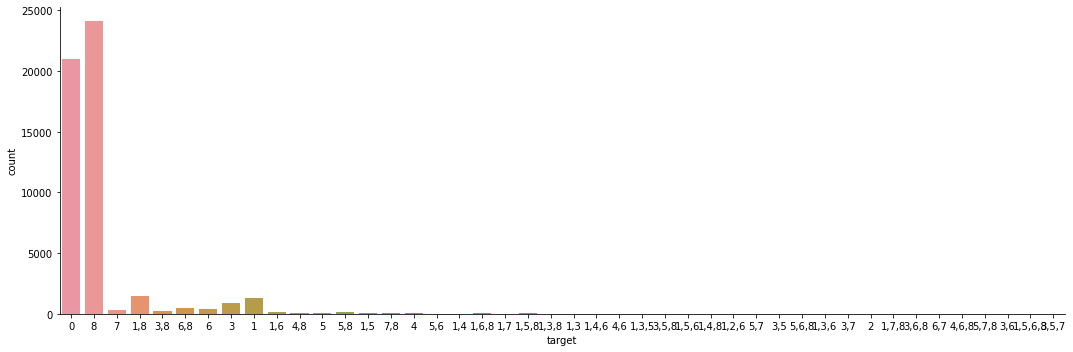

In [11]:
sns.catplot(kind='count', x='target', data=train_df, aspect=3)

In [12]:
targets_df = train_df['target'].str.split(',', expand=True)
targets_df.head()

,0,1,2,3
0,0,None,None,None
1,8,None,None,None
2,0,None,None,None
3,0,None,None,None
4,8,None,None,None


In [13]:
train_expand_df = pd.concat([train_df.assign(target=targets_df[t]) 
                             for t in targets_df.columns], )
train_expand_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203504 entries, 0 to 50875
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   review_id             203504 non-null  int64 
 1   city                  190100 non-null  object
 2   position              184872 non-null  object
 3   positive              203348 non-null  object
 4   negative              202956 non-null  object
 5   salary_rating         203504 non-null  int64 
 6   team_rating           203504 non-null  int64 
 7   managment_rating      203504 non-null  int64 
 8   career_rating         203504 non-null  int64 
 9   workplace_rating      203504 non-null  int64 
 10  rest_recovery_rating  203504 non-null  int64 
 11  target                53753 non-null   object
dtypes: int64(7), object(5)
memory usage: 20.2+ MB


In [14]:
train_expand_df = train_expand_df.loc[train_expand_df['target'].notna(), :]
train_expand_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53753 entries, 0 to 41118
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   review_id             53753 non-null  int64 
 1   city                  50263 non-null  object
 2   position              48993 non-null  object
 3   positive              53714 non-null  object
 4   negative              53616 non-null  object
 5   salary_rating         53753 non-null  int64 
 6   team_rating           53753 non-null  int64 
 7   managment_rating      53753 non-null  int64 
 8   career_rating         53753 non-null  int64 
 9   workplace_rating      53753 non-null  int64 
 10  rest_recovery_rating  53753 non-null  int64 
 11  target                53753 non-null  object
dtypes: int64(7), object(5)
memory usage: 5.3+ MB


In [15]:
train_expand_df['target'] = train_expand_df['target'].astype(int, copy=False)
train_expand_df.dtypes

review_id                int64
city                    object
position                object
positive                object
negative                object
salary_rating            int64
team_rating              int64
managment_rating         int64
career_rating            int64
workplace_rating         int64
rest_recovery_rating     int64
target                   int64
dtype: object

In [16]:
train_expand_df['target'].value_counts().sort_index()

0    21003
1     3117
2       13
3     1139
4      111
5      376
6     1069
7      391
8    26534
Name: target, dtype: int64

In [17]:
train_expand_df['targets_count'] = train_df['target'].apply(lambda x: len(x.split(',')))

In [18]:
train_expand_df.groupby('targets_count')['review_id'].nunique()

targets_count
1    48116
2     2644
3      115
4        1
Name: review_id, dtype: int64

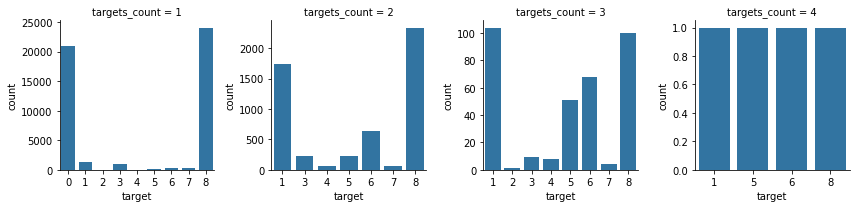

In [19]:
grid = sns.FacetGrid(train_expand_df, 
                     col='targets_count',
                     sharex=False, sharey=False,)
grid.map_dataframe(sns.countplot, x='target')

In [20]:
targets_pivot_df = train_expand_df.pivot(index='review_id', columns=['target'], values=['target'])
targets_pivot_df.head()

target                                 
target         0   1   2   3   4   5   6   7    8
review_id                                        
0            0.0 NaN NaN NaN NaN NaN NaN NaN  NaN
1            NaN NaN NaN NaN NaN NaN NaN NaN  8.0
2            0.0 NaN NaN NaN NaN NaN NaN NaN  NaN
5            0.0 NaN NaN NaN NaN NaN NaN NaN  NaN
7            NaN NaN NaN NaN NaN NaN NaN NaN  8.0

In [21]:
def get_combin(dataframe, k):
    result_df = pd.DataFrame(index=dataframe.index)
    for items in combinations(range(0, 9), k):
        mask = pd.Series(np.ones(len(result_df)),
                         index=result_df.index).astype(bool)
        for i in items:
            mask &= dataframe['target'][i].notna()
        name = '_'.join([str(i) for i in items])
        result_df[name] = mask.astype(int)
    return result_df

<AxesSubplot:>

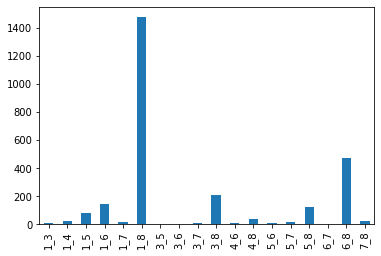

In [22]:
idxs = train_expand_df[train_expand_df['targets_count'] == 2]['review_id'].unique()
targets_comb2_df = get_combin(targets_pivot_df[targets_pivot_df.index.isin(idxs)], 2).sum()
targets_comb2_df[targets_comb2_df != 0].plot.bar()

In [23]:
targets_comb2_df[targets_comb2_df == 0].index.tolist()

['0_1',
 '0_2',
 '0_3',
 '0_4',
 '0_5',
 '0_6',
 '0_7',
 '0_8',
 '1_2',
 '2_3',
 '2_4',
 '2_5',
 '2_6',
 '2_7',
 '2_8',
 '3_4',
 '4_5',
 '4_7']

<AxesSubplot:>

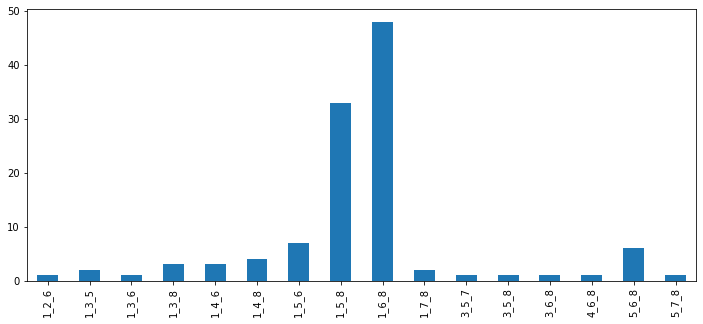

In [24]:
idxs = train_expand_df[train_expand_df['targets_count'] == 3]['review_id'].unique()
targets_comb3_df = get_combin(targets_pivot_df[targets_pivot_df.index.isin(idxs)], 3).sum()
plt.figure(figsize=(12, 5))
targets_comb3_df[targets_comb3_df != 0].plot.bar()

In [25]:
pairs_df = get_combin(targets_pivot_df, 2).sum().to_frame()
pairs_df.head()

,0
0_1,0
0_2,0
0_3,0
0_4,0
0_5,0


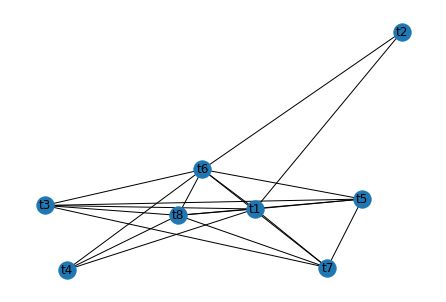

In [26]:
graph = Graph()
_ = [graph.add_node(f't{i}') for i in range(1, 9)]
for pair, count in pairs_df.itertuples():
    if count == 0:
        continue
    i1, i2, = pair.split('_')
    graph.add_edge(f't{i1}', f't{i2}', weight=np.sqrt(count))
draw(graph, with_labels=True)

## Город

Всего в train и test есть около 1 тыс населенных пунктов, в основном российсиких, но есть и украинские, белорусские и казахстанские.  
Следует заметить:
- по типу это в основном крупные города: Москва, Питер и т.д.  
- если посмотреть в разрезе таргета на рапределения типа города и населения, то можно заметить чуть более высокую долю деревень (с начслением до 10 тыс) для причин 1-8.
- если посмотреть в разрезе таргета на рапределения стран никаких зависимостей не наблюдается.  
- между распределениями в train и test значимых отличий нет.

##### Код:

In [27]:
total_df = pd.concat([train_df.assign(sample='train'),
                      test_df.assign(sample='test'), ])
total_df.head()

,review_id,city,position,positive,negative,salary_rating,team_rating,managment_rating,career_rating,workplace_rating,rest_recovery_rating,target,sample
0,0,Ижевск,Кладовщик,Недавно устроился в ****** на должность кладов...,Повысить з/п,5,4,3,3,4,4,0,train
1,1,Москва,Руководитель проекта,"Расположение офиса, своего рода стабильность (...",Упростить процессы - все процессы ради процесс...,4,4,4,1,1,1,8,train
2,2,Екатеринбург,Консультант,В нашем банке все по закону в плане зарплаты и...,Ничего,5,5,5,5,5,5,0,train
3,5,Санкт-Петербург,Оператор,Я в ****** около года работаю оператором. Норм...,Нет.,5,5,5,5,5,5,0,train
4,7,Москва,Инженер КИПиА,В принципе норм.Работать можно,Всегда есть к чему стремиться,4,5,4,2,5,2,8,train


In [28]:
total_df['city'] = total_df['city'].str.strip()

In [29]:
total_df['city'].nunique()

1098

In [30]:
total_df['city'].value_counts()[:20]

Москва             47938
Санкт-Петербург     9525
Краснодар           3020
Екатеринбург        1692
Нижний Новгород     1508
Казань              1245
Челябинск           1239
Новосибирск         1209
Ростов-на-Дону      1201
Воронеж             1077
Самара              1068
Уфа                  862
Киев                 786
Пермь                713
Владивосток          693
Тюмень               632
Саратов              626
Омск                 569
Красноярск           554
Волгоград            547
Name: city, dtype: int64

In [31]:
total_df.groupby('sample')['city'].nunique()

sample
test     815
train    852
Name: city, dtype: int64

In [32]:
value_counts = lambda s: total_df.loc[total_df['sample'] == s, 'city'].value_counts().reset_index()
cities_df = pd.merge(value_counts('train'),
                     value_counts('test'),
                     how='outer',
                     on='index', )
cities_df.head()

,index,city_x,city_y
0,Москва,23436.0,24502.0
1,Санкт-Петербург,4841.0,4684.0
2,Краснодар,1436.0,1584.0
3,Екатеринбург,836.0,856.0
4,Нижний Новгород,782.0,726.0


In [33]:
cities_df = cities_df.fillna(0).astype({'city_x': int, 'city_y': int, })
cities_df.loc[cities_df['city_x'] == 0, 'flag'] = 'only_test'
cities_df.loc[cities_df['city_y'] == 0, 'flag'] = 'only_train'
cities_df.loc[cities_df['flag'].isna(), 'flag'] = 'both'
cities_df.head()

,index,city_x,city_y,flag
0,Москва,23436,24502,both
1,Санкт-Петербург,4841,4684,both
2,Краснодар,1436,1584,both
3,Екатеринбург,836,856,both
4,Нижний Новгород,782,726,both


In [34]:
cities_df.columns = ['name',
                     'train_review_qty',
                     'test_review_qty',
                     'flag', ]
cities_df.head()

,name,train_review_qty,test_review_qty,flag
0,Москва,23436,24502,both
1,Санкт-Петербург,4841,4684,both
2,Краснодар,1436,1584,both
3,Екатеринбург,836,856,both
4,Нижний Новгород,782,726,both


In [35]:
cities_df['train_review_frac'] = cities_df['train_review_qty'] / train_df.shape[0]
cities_df['test_review_frac'] = cities_df['train_review_qty'] / test_df.shape[0]
cities_df.head()

,name,train_review_qty,test_review_qty,flag,train_review_frac,test_review_frac
0,Москва,23436,24502,both,0.460649,0.462696
1,Санкт-Петербург,4841,4684,both,0.095153,0.095576
2,Краснодар,1436,1584,both,0.028225,0.028351
3,Екатеринбург,836,856,both,0.016432,0.016505
4,Нижний Новгород,782,726,both,0.015371,0.015439


<AxesSubplot:xlabel='flag', ylabel='count'>

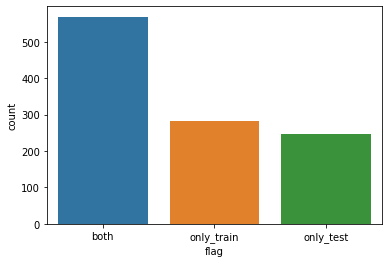

In [36]:
sns.countplot(data=cities_df, x='flag')

In [37]:
cities_df[cities_df['flag'] == 'only_train']['train_review_qty'].describe()

count    283.000000
mean       1.530035
std        1.483353
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max       17.000000
Name: train_review_qty, dtype: float64

In [38]:
cities_df[cities_df['flag'] == 'only_test']['test_review_qty'].describe()

count    246.000000
mean       1.243902
std        0.636848
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        5.000000
Name: test_review_qty, dtype: float64

In [39]:
nominatim = Nominatim()

In [40]:
area_ids = [nominatim.query(country).areaId() 
            for country in ['Россия', 'Украина', 'Белоруссия', 'Казахстан']]
!rm -fR ./cache
area_ids

[nominatim] downloading data: search
[nominatim] downloading data: search
[nominatim] downloading data: search
[nominatim] downloading data: search


[3600060189, 3600060199, 3600059065, 3600214665]

In [41]:
with open('data/osm_data_raw.geojson', 'r', encoding='utf-8') as file:
    osm_data = geojson.load(file)

In [42]:
osm_data.keys()

dict_keys(['type', 'generator', 'copyright', 'timestamp', 'features'])

In [43]:
len(osm_data['features'])

78100

In [44]:
 osm_data_df = gpd.GeoDataFrame.from_features(osm_data['features'])
 osm_data_df.head()

,geometry,@id,admin_level,capital,name,name:ar,name:be,name:ca,name:cs,name:da,...,old_name:mo,old_name:sg,abandoned:village,addr:reg,old_name:inh,alt_official_name,KN,alt_name:lbe,address,tourism
0,POINT (82.92345 55.02822),node/54,3,3,Новосибирск,نوفوسيبيرسك,Новасібірск,Novossibirsk,Novosibirsk,Novosibirsk,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,POINT (30.52414 50.45003),node/26150422,NaN,yes,Київ,كييف,Кіеў,Kíiv,Kyjev,Kyiv,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,POINT (31.29433 51.49410),node/26150436,NaN,4,Чернігів,NaN,Чарнігаў,Txerníhiv,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,POINT (30.73928 46.48732),node/26150437,NaN,4,Одеса,أوديسا,Адэса,Odessa,Oděsa,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,POINT (24.03159 49.84195),node/26150791,4,4,Львів,لفيف,Львоў,Lviv,Lvov,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
properties = ['addr:country', 'name', 'name:ru', 'place', 'population', 'geometry', ]

In [46]:
osm_data_df[properties].info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 78100 entries, 0 to 78099
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   addr:country  31467 non-null  object  
 1   name          78031 non-null  object  
 2   name:ru       49597 non-null  object  
 3   place         78100 non-null  object  
 4   population    51862 non-null  object  
 5   geometry      78100 non-null  geometry
dtypes: geometry(1), object(5)
memory usage: 3.6+ MB


In [47]:
osm_cities_df = pd.DataFrame(index=osm_data_df.index)
osm_cities_df.head()

""
0
1
2
3
4


In [48]:
osm_cities_df['country'] = osm_data_df['addr:country'].str.strip()
osm_cities_df['type'] = osm_data_df['place'].str.strip()
osm_cities_df['name'] = osm_data_df['name:ru'].combine_first(osm_data_df['name']).str.strip()
osm_cities_df.describe()

,country,type,name
count,31467,78100,78034
unique,4,5,49646
top,RU,village,Александровка
freq,25229,68243,199


In [49]:
def parse_population(input: str):
    digit_str = input.split('(')[0].strip()
    digit_str = ''.join(filter(str.isdigit, digit_str))
    if digit_str.isnumeric():
        return int(digit_str)
    return np.nan

osm_cities_df['population'] = osm_data_df['population'].astype(str).map(parse_population).replace(0, np.nan)
osm_cities_df['population'].describe()

count    5.183900e+04
mean     3.935823e+03
std      6.994596e+04
min      1.000000e+00
25%      2.780000e+02
50%      5.260000e+02
75%      1.127000e+03
max      1.265505e+07
Name: population, dtype: float64

In [50]:
osm_cities_df['latitude'] = osm_data_df['geometry'].x
osm_cities_df['longitude'] = osm_data_df['geometry'].y

In [51]:
osm_cities_df = osm_cities_df[osm_cities_df['name'].notna()]

In [52]:
osm_cities_df.head()

,country,type,name,population,latitude,longitude
0,NaN,city,Новосибирск,1620162.0,82.923451,55.028217
1,NaN,city,Киев,2909697.0,30.524136,50.450034
2,NaN,city,Чернигов,293969.0,31.294332,51.494099
3,NaN,city,Одесса,1008852.0,30.739278,46.487319
4,NaN,city,Львов,724822.0,24.031592,49.841952


In [53]:
osm_cities_df.describe(include='all')

,country,type,name,population,latitude,longitude
count,31464,78034,78034,5.183900e+04,78034.000000,78034.000000
unique,4,5,49646,NaN,NaN,NaN
top,RU,village,Александровка,NaN,NaN,NaN
freq,25229,68221,199,NaN,NaN,NaN
mean,NaN,NaN,NaN,3.935823e+03,46.138259,51.823860
std,NaN,NaN,NaN,6.994596e+04,23.382637,4.371970
min,NaN,NaN,NaN,1.000000e+00,-179.480310,40.600187
25%,NaN,NaN,NaN,2.780000e+02,31.553003,48.944041
50%,NaN,NaN,NaN,5.260000e+02,38.394219,51.389975
75%,NaN,NaN,NaN,1.127000e+03,51.717843,54.828777


In [54]:
osm_cities_df['name'].nunique()

49646

In [55]:
osm_cities_df = osm_cities_df.sort_values(['name', 'population']).drop_duplicates(subset=['name'], )

In [56]:
cities_df = cities_df.merge(osm_cities_df, how='left', on='name')
cities_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098 entries, 0 to 1097
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               1098 non-null   object 
 1   train_review_qty   1098 non-null   int64  
 2   test_review_qty    1098 non-null   int64  
 3   flag               1098 non-null   object 
 4   train_review_frac  1098 non-null   float64
 5   test_review_frac   1098 non-null   float64
 6   country            793 non-null    object 
 7   type               1048 non-null   object 
 8   population         1036 non-null   float64
 9   latitude           1048 non-null   float64
 10  longitude          1048 non-null   float64
dtypes: float64(5), int64(2), object(4)
memory usage: 102.9+ KB


In [57]:
del osm_data, osm_data_df, osm_cities_df

<AxesSubplot:xlabel='country', ylabel='count'>

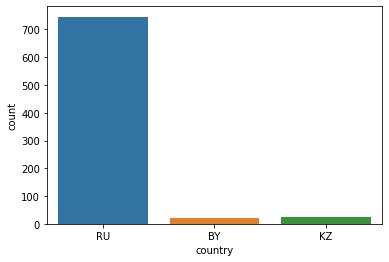

In [58]:
sns.countplot(data=cities_df, x='country')

<AxesSubplot:xlabel='type', ylabel='count'>

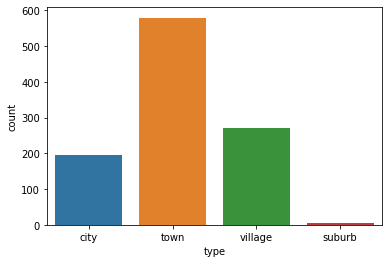

In [59]:
sns.countplot(data=cities_df, x='type')

<AxesSubplot:xlabel='population', ylabel='Count'>

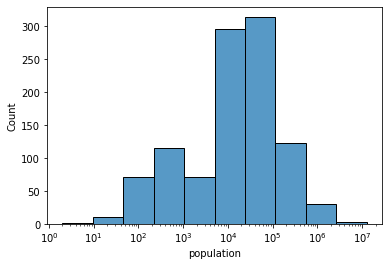

In [60]:
sns.histplot(data=cities_df, x='population', bins=10, log_scale=True)

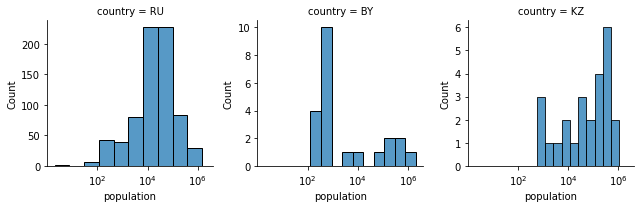

In [61]:
grid = sns.FacetGrid(data=cities_df,
                     col='country', 
                     sharey=False, )
grid.map_dataframe(sns.histplot, x='population', bins=10, log_scale=True)

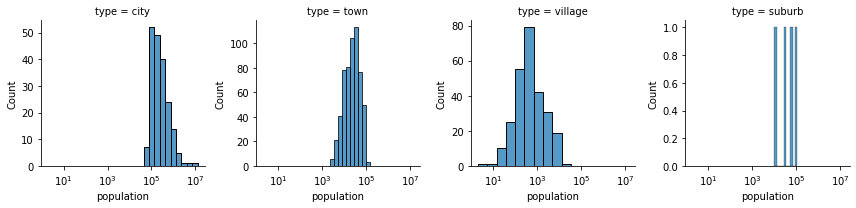

In [62]:
grid = sns.FacetGrid(data=cities_df,
                     col='type', 
                     sharey=False, )
grid.map_dataframe(sns.histplot, x='population', bins=10, log_scale=True)

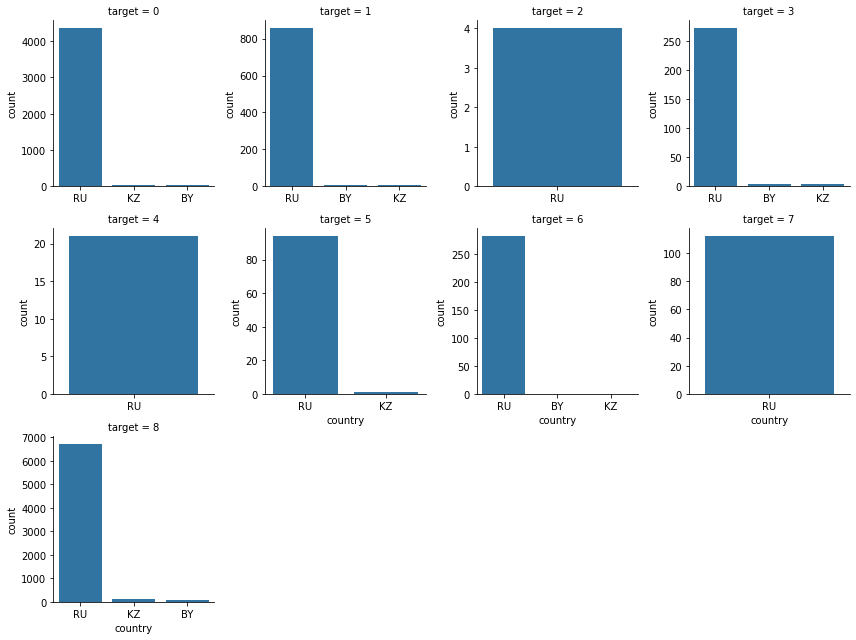

In [63]:
grid = sns.FacetGrid(train_expand_df.merge(cities_df, how='left', left_on='city', right_on='name'),
                     col='target', col_wrap=4,
                     sharex=False, sharey=False, )
grid.map_dataframe(sns.countplot, x='country')

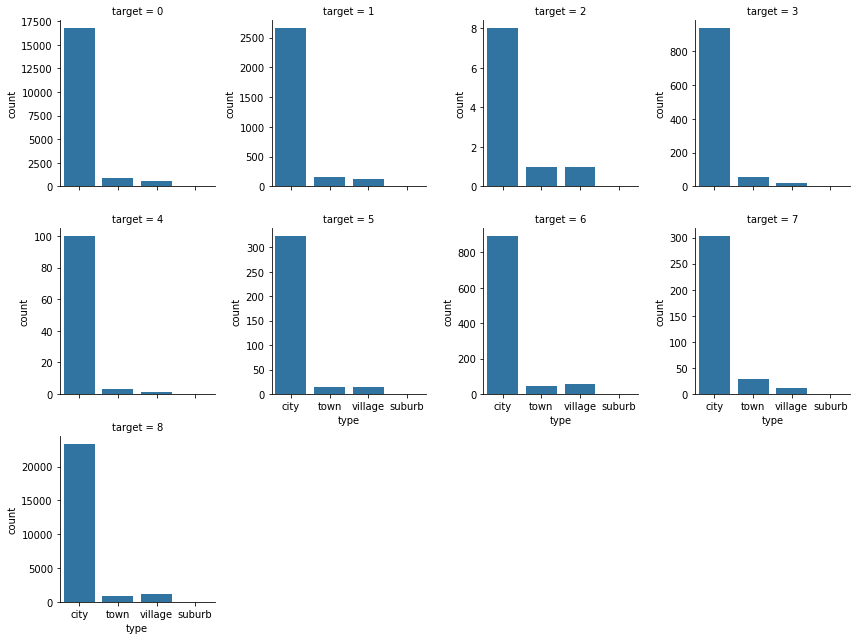

In [64]:
grid = sns.FacetGrid(train_expand_df.merge(cities_df, how='left', left_on='city', right_on='name'),
                     col='target', col_wrap=4,
                     sharex=True, sharey=False, )
grid.map_dataframe(sns.countplot, x='type')

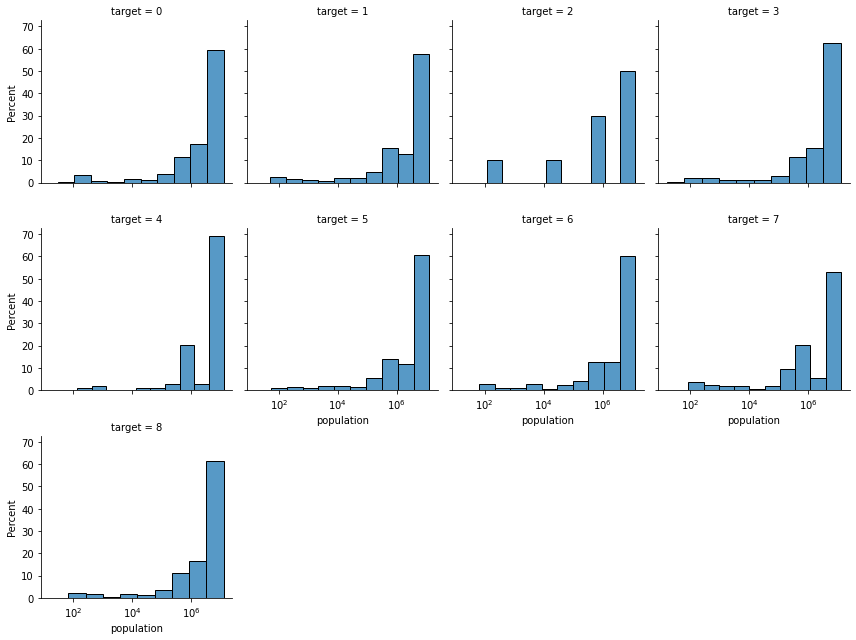

In [65]:
grid = sns.FacetGrid(train_expand_df.merge(cities_df, how='left', left_on='city', right_on='name'),
                     col='target', col_wrap=4,
                     sharex=True, sharey=True, )
grid.map_dataframe(sns.histplot, x='population', stat='percent', bins=10, log_scale=True)

## Должность

В train и test есть около 22 тыс. уникальных наименований должности, в основном это продавцы и менеджеры.   
Можно заметить что это поле может быть заполнено либо только на русском или английском, либо на обоих языках сразу.   
Кроме того поле может состоять из одного и более слов.  
Также оно может содержать название компании которое "цензурится" с помощью "******".  
Если посмотреть в разрезе языка, то можно заметить:
- в основном это только русский;
- **NaN-ов в train больше чем в test**;
- **кол-во NaN-ов в причине 0 больше чем в других**, в остальном отличий нет;

Если посмотреть в разрезе кол-ва слов, то можно заметить:
- в целом название должности состоит из 2, 1 или 3 слова;
- встречаются достаточно длинные названия до 26 слов;
- длинные названия харатерны для должностей написанных только на русском;
- **в test гораздо больше "русских" должностей состоящих из 2 и 3 слов**;
- **для прицины 0 преобладают должности с 1 словом**, в то время как для остальных причин с 2 или 3 словами (особенно для "русских" должностей);

Если посмотреть на должности в которых есть название компании, то можно заметить:
- как правило название компании чаще встречаятся в должностях написанных на русском и английском, а также для должностей состоящий более чем одного слова;
- чем больше слов в названии должности тем вероятнее что в нем есть название компании;
- есть должности в которых написано только название компании;
- **наличие названия компании наиболее характерно для причины 8**.

Помимо всего вышеуказанного, следует заметить, что в названии должности может быть "тарабарщина" (только цифры или знаки препинания). **Для отзывов с такими названиями должностей характерно что они не проходят модерацию**.

##### Код:

In [66]:
total_df[total_df['sample'] == 'train']['position'].value_counts()[:20]

Продавец-консультант                2145
Продавец-кассир                     1407
Менеджер                            1204
Менеджер по продажам                1088
Продавец                             838
Менеджер по работе с клиентами       769
Администратор                        615
Директор магазина                    554
Оператор                             516
Специалист по работе с клиентами     514
Кладовщик                            496
Кассир                               407
Торговый представитель               402
Специалист                           399
Водитель                             356
Охранник                             318
Курьер                               309
Оператор call-центра                 295
Инженер                              294
Консультант                          279
Name: position, dtype: int64

In [67]:
total_df[total_df['sample'] == 'test']['position'].value_counts()[:20]

Продавец-консультант                2310
Продавец-кассир                     1563
Менеджер по продажам                 896
Менеджер по работе с клиентами       819
Специалист по работе с клиентами     646
Администратор                        630
Директор магазина                    590
Специалист                           573
Менеджер                             554
Кладовщик                            427
Торговый представитель               411
Оператор call-центра                 377
Продавец                             365
Кассир                               364
Ведущий специалист                   330
Специалист по продажам               303
Оператор                             297
Водитель-экспедитор                  294
Кредитный специалист                 279
Инженер                              270
Name: position, dtype: int64

In [68]:
total_df['position'].nunique()                     

22317

In [69]:
import string

In [70]:
def preproc_str(input_str: str) -> str:
    output_str = input_str.lower()

    table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    output_str = output_str.translate(table)

    output_str = ''.join(list(filter(lambda x: not x.isnumeric(), output_str)))

    output_str = output_str.strip()

    output_str = unicodedata.normalize('NFKD', output_str)

    return output_str

In [71]:
mask = total_df['position'].notna()
total_df.loc[mask, 'position_preproc'] = total_df[mask]['position'].apply(lambda x: preproc_str(x))
total_df['position_preproc'].head()

0               кладовщик
1    руководитель проекта
2             консультант
3                оператор
4           инженер кипиа
Name: position_preproc, dtype: object

In [72]:
all_words = ' '.join(total_df[total_df['position'].notna()]['position_preproc'])
all_words[:100]

'кладовщик руководитель проекта консультант оператор инженер кипиа менеджер international reporting a'

In [73]:
def plot_words(text: str):
    plt.figure(figsize=(12, 12))
    wordcloud = WordCloud(background_color='white',
                        max_words=200,
                        width=5000, height=1500, )
    plt.imshow(wordcloud.generate(text))
    plt.axis('off')
    plt.show()

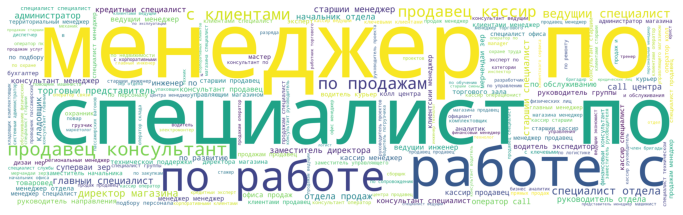

In [74]:
plot_words(all_words)

<AxesSubplot:xlabel='position_lang', ylabel='count'>

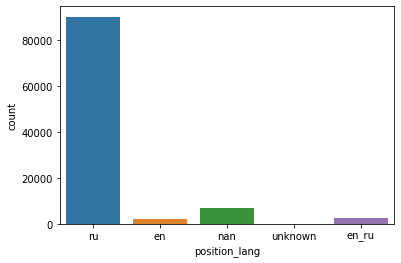

In [75]:
total_df['position_lang'] = total_df['position_preproc'].apply(str)
total_df.loc[total_df['position_preproc'].notna(), 'position_lang'] = 'unknown'
total_df.loc[total_df['position_preproc'].notna() & total_df['position_preproc'].str.contains('[a-zA-Z]+'),'position_lang'] = 'en'
total_df.loc[total_df['position_preproc'].notna() & total_df['position_preproc'].str.contains('[а-яА-Я]+'),'position_lang'] = 'ru'
total_df.loc[total_df['position_preproc'].notna() & total_df['position_preproc'].str.contains('[a-zA-Z]+') & total_df['position_preproc'].str.contains('[а-яА-Я]+'),'position_lang'] = 'en_ru'
sns.countplot(data=total_df, x='position_lang')

In [76]:
total_df[total_df['position_lang'] == 'unknown']['position'].unique()

array(['5662', '-', '????????', '...', '.....', '1321', '25', '23', '.',
       '1', '--', '2770', '!!!!!!', '20'], dtype=object)

In [77]:
total_df[total_df['position_lang'] == 'en_ru']['position'].value_counts()

Оператор call-центра                              672
HR-менеджер                                        88
Специалист call-центра                             62
IT специалист                                      45
Frontend-разработчик                               39
                                                 ... 
Специалист BTS                                      1
Главный менеджер - Team lead                        1
Менеджер по продажам KAS (key account service)      1
Оператор call-центра горячая линия                  1
Специалист смены b2b2c                              1
Name: position, Length: 1255, dtype: int64

In [78]:
total_df[total_df['position_lang'] == 'en']['position'].value_counts()

Project Manager                                  60
Product Manager                                  39
Manager                                          37
Intern                                           31
QA Engineer                                      29
                                                 ..
Regional Trade Marketing Specialist Off Trade     1
OeBS support specialist                           1
Head of M&A stream, Strategy division             1
Trade marketing specialist                        1
Access Manager                                    1
Name: position, Length: 1244, dtype: int64

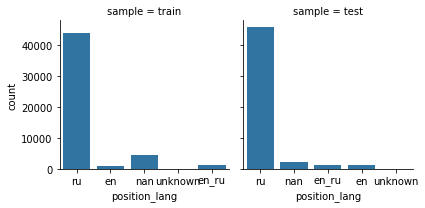

In [79]:
grid = sns.FacetGrid(data=total_df,
                     col='sample',
                     sharex=False, )
grid.map_dataframe(sns.countplot, x='position_lang', )

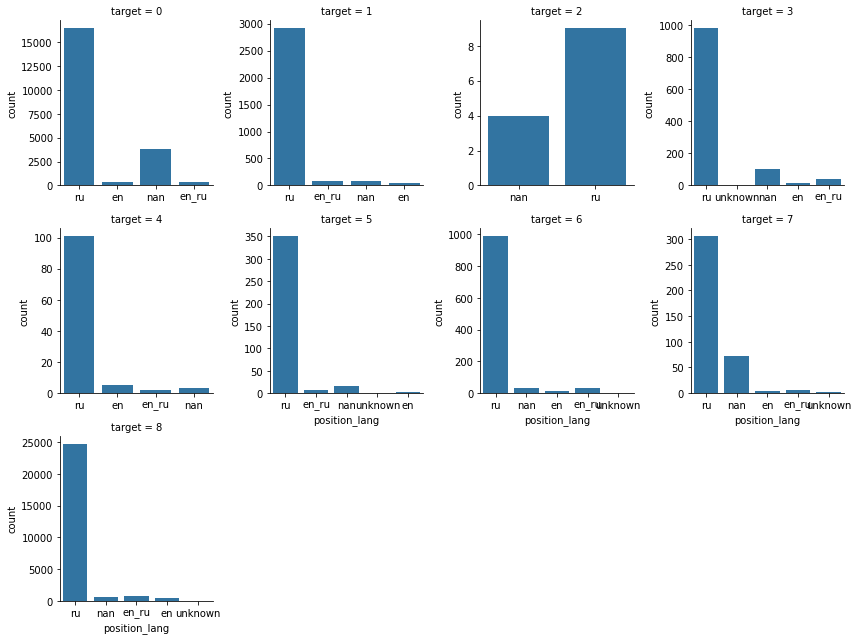

In [80]:
grid = sns.FacetGrid(data=train_expand_df.merge(total_df[['review_id', 'position_lang']], how='left', on='review_id'),
                     col='target', col_wrap=4,
                     sharex=False, sharey=False,)
grid.map_dataframe(sns.countplot, x='position_lang', )

In [81]:
ru_stop_words = stopwords.words('russian')
en_stop_words = stopwords.words('english')
all_stop_words = ru_stop_words + en_stop_words
all_stop_words[:5], all_stop_words[-5:]

(['и', 'в', 'во', 'не', 'что'],
 ["weren't", 'won', "won't", 'wouldn', "wouldn't"])

In [82]:
def tokenize(input_str: str, stop_words: list[str]) -> list[str]:
    tokens = [t for t in input_str.split() if t not in stop_words]
    return tokens

tokenize('Dad is bad', en_stop_words), tokenize('Меч в ножнах', ru_stop_words)

(['Dad', 'bad'], ['Меч', 'ножнах'])

In [83]:
total_df['position_tokens_count'] = 0

In [84]:
mask = total_df['position_lang'] == 'ru'
total_df.loc[mask, 'position_tokens_count'] = total_df[mask]['position_preproc'].apply(lambda x: len(tokenize(x, ru_stop_words)))

In [85]:
mask = total_df['position_lang'] == 'en'
total_df.loc[mask, 'position_tokens_count'] = total_df[mask]['position_preproc'].apply(lambda x: len(tokenize(x, en_stop_words)))

In [86]:
mask = total_df['position_lang'] == 'en_ru'
total_df.loc[mask, 'position_tokens_count'] = total_df[mask]['position_preproc'].apply(lambda x: len(tokenize(x, all_stop_words)))

In [87]:
total_df['position_tokens_count'].describe()

count    101527.000000
mean          2.294601
std           1.561429
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          26.000000
Name: position_tokens_count, dtype: float64

<AxesSubplot:xlabel='position_tokens_count', ylabel='count'>

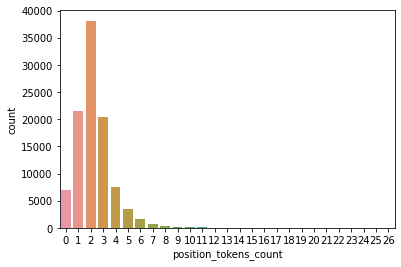

In [88]:
sns.countplot(data=total_df, x='position_tokens_count')

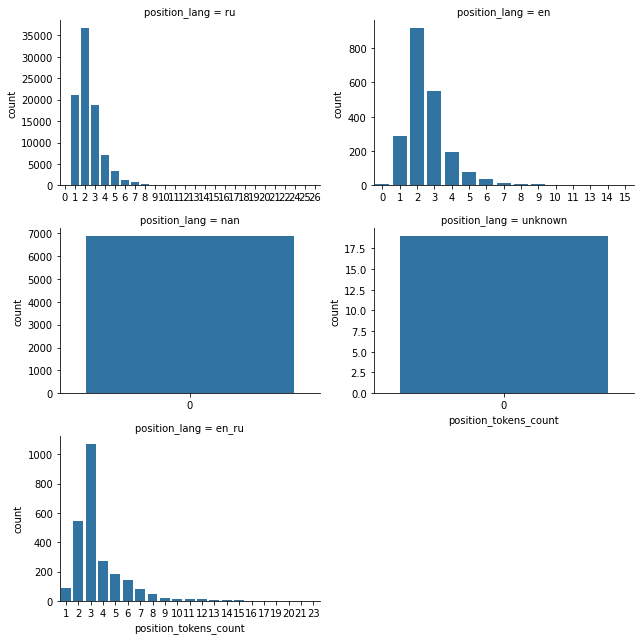

In [89]:
grid = sns.FacetGrid(total_df,
                     col='position_lang', col_wrap=2,
                     sharex=False, sharey=False, 
                     aspect=1.5, )
grid.map_dataframe(sns.countplot, x='position_tokens_count')

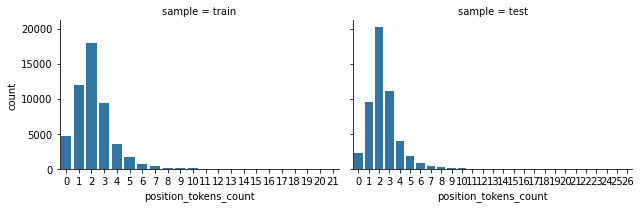

In [90]:
grid = sns.FacetGrid(total_df,
                     col='sample', 
                     sharex=False, 
                     aspect=1.5, )
grid.map_dataframe(sns.countplot, x='position_tokens_count')

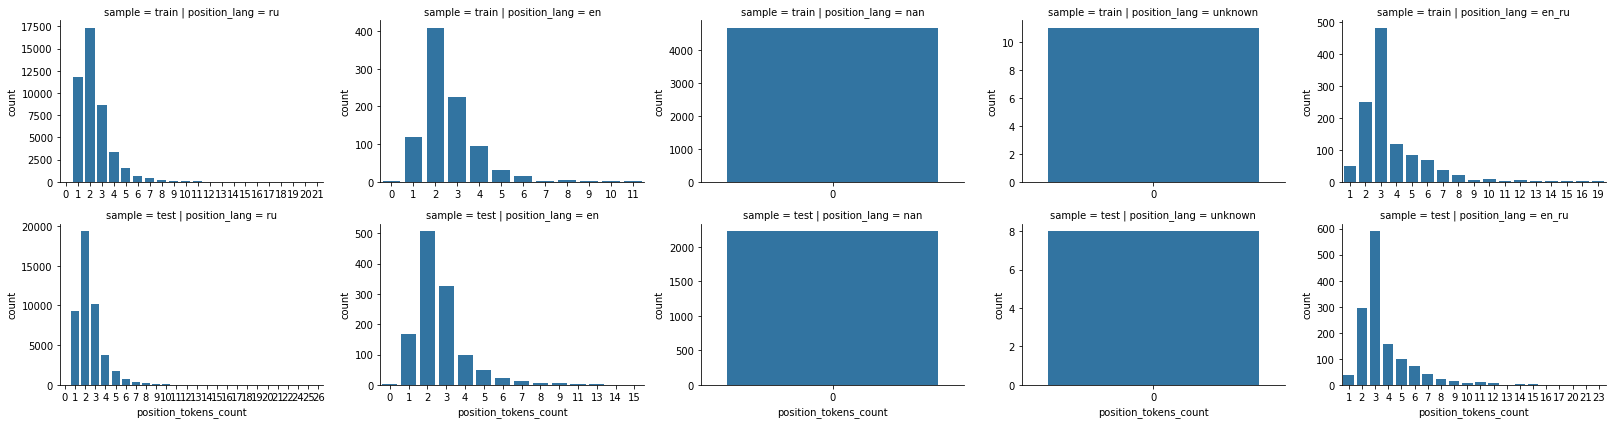

In [91]:
grid = sns.FacetGrid(total_df,
                     row='sample', col='position_lang', 
                     sharex=False, sharey=False, 
                     aspect=1.5, )
grid.map_dataframe(sns.countplot, x='position_tokens_count')

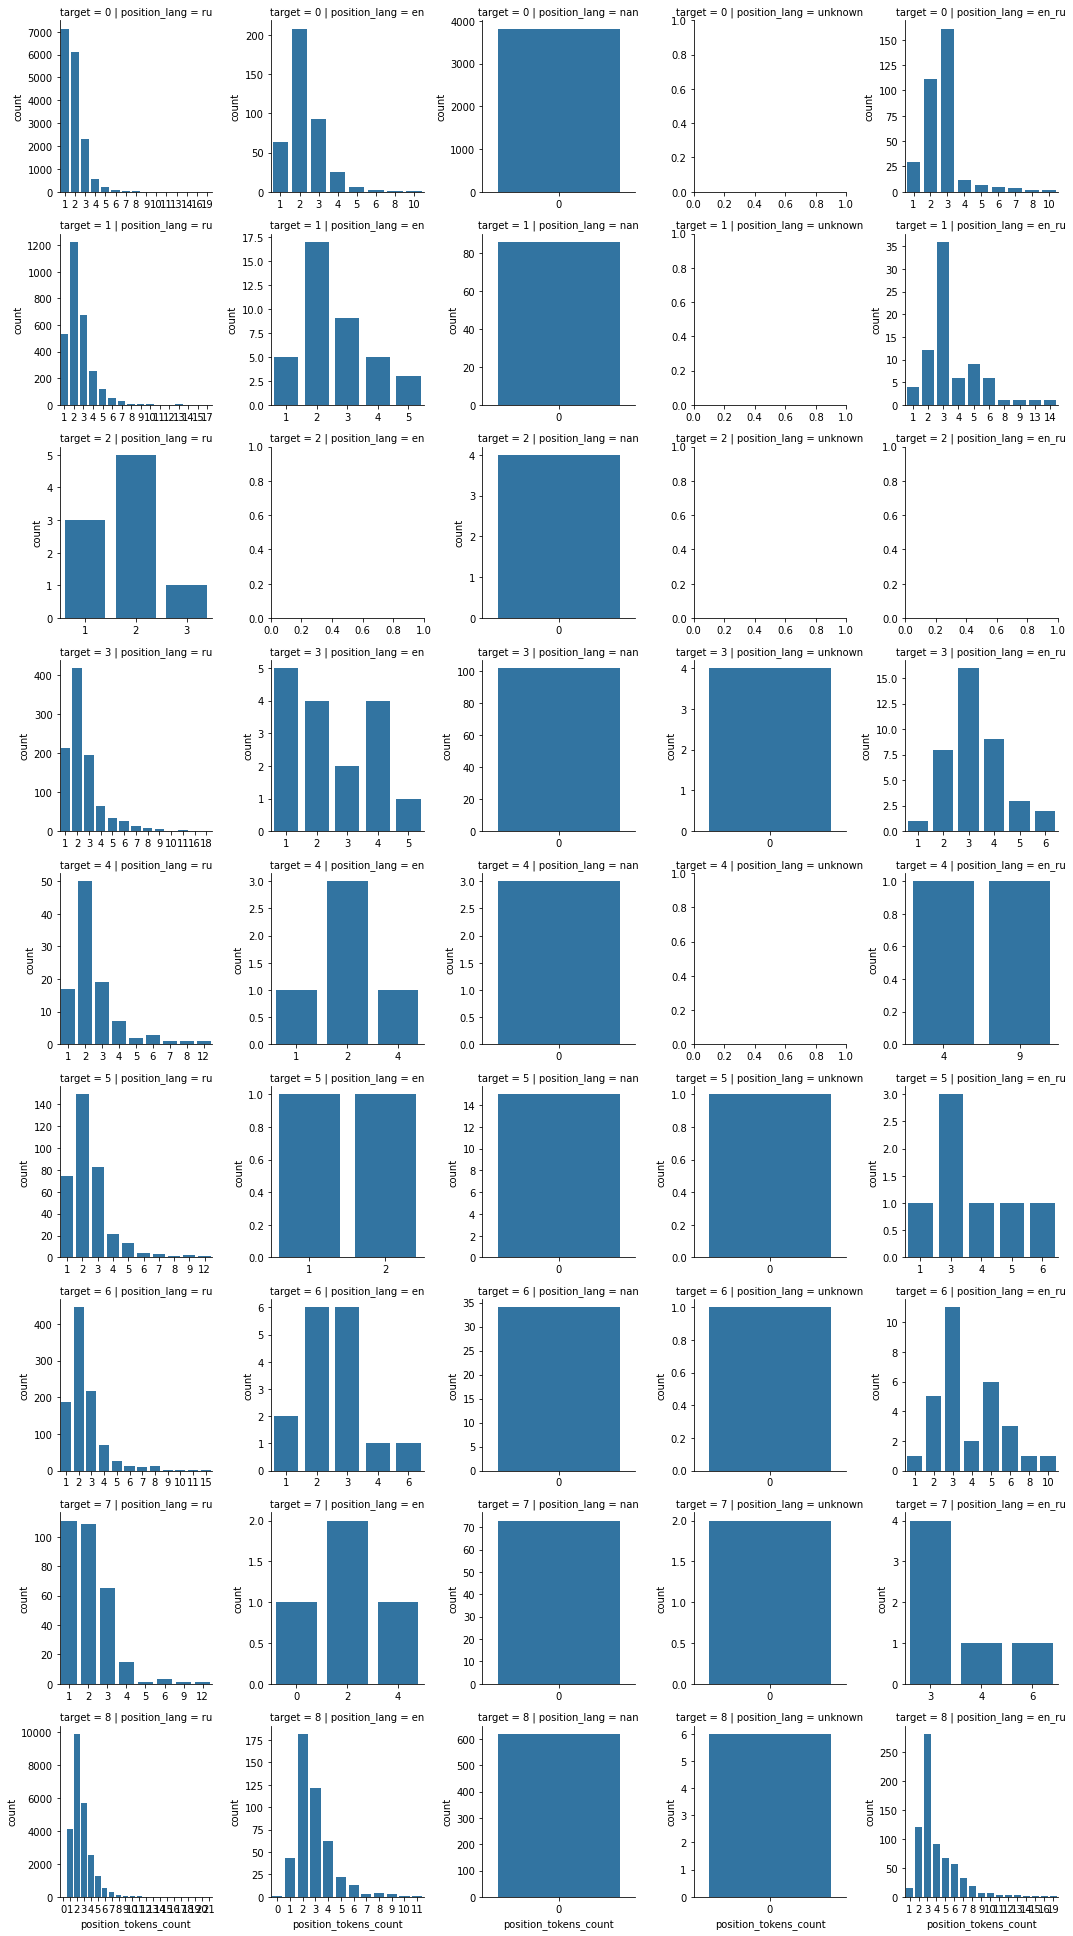

In [92]:
grid = sns.FacetGrid(train_expand_df.merge(total_df[['review_id', 'position_lang', 'position_tokens_count']], how='left', on='review_id'),
                     row='target', col='position_lang', 
                     sharex=False, sharey=False, )
grid.map_dataframe(sns.countplot, x='position_tokens_count')

In [93]:
morph = pymorphy2.MorphAnalyzer()

In [94]:
morph.parse('ножнах')[0].normal_form

'ножны'

In [95]:
lemma = WordNetLemmatizer()

In [96]:
ru_normalize = lambda x: morph.parse(x)[0].normal_form
def en_normalize(token: str) -> str:
    _, key = pos_tag([token])[0]
    if key.startswith('J'):
        pos = wordnet.ADJ
    elif key.startswith('V'):
        pos = wordnet.VERB
    elif key.startswith('N'):
        pos = wordnet.NOUN
    elif key.startswith('R'):
        pos = wordnet.ADV
    else:
        pos = wordnet.NOUN
    return lemma.lemmatize(token, pos=pos)
normalize = lambda x: en_normalize(x) if re.search('[a-zA-Z]+', x) else ru_normalize(x)

In [97]:
normalize('делал'), normalize('was')

('делать', 'be')

In [98]:
def position_normalize(input_str: str) -> str:
    tokens = tokenize(input_str, all_stop_words)
    return " ".join([normalize(t) for t in tokens])

In [99]:
mask = total_df['position_preproc'].notna() & (total_df['position_preproc'].str.len() != 0)
total_df.loc[mask, 'position_norm'] = total_df[mask]['position_preproc'].apply(position_normalize)
total_df['position_norm'].head()

0              кладовщик
1    руководитель проект
2            консультант
3               оператор
4          инженер кипиа
Name: position_norm, dtype: object

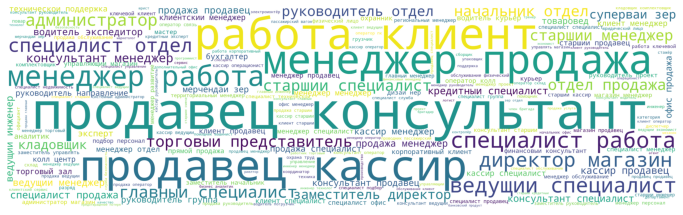

In [100]:
ru_words = ' '.join(total_df[total_df['position_lang'] == 'ru']['position_norm'])
plot_words(ru_words)

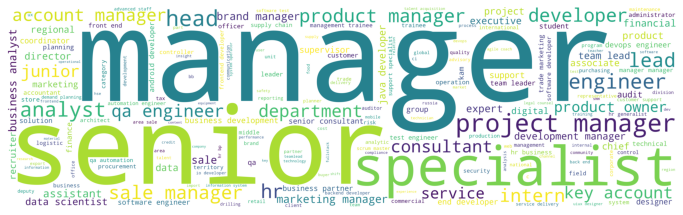

In [101]:
en_words = ' '.join(total_df[total_df['position_lang'] == 'en']['position_norm'])
plot_words(en_words)

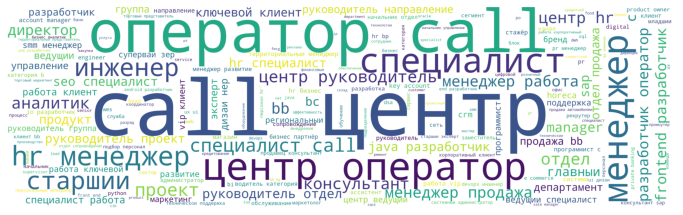

In [102]:
en_ru_words = ' '.join(total_df[total_df['position_lang'] == 'en_ru']['position_norm'])
plot_words(en_ru_words)

In [103]:
mask = total_df['position'].notna()
total_df.loc[mask, 'position_have_company'] = total_df[mask]['position'].str.contains('[\*]+').astype(int)

In [104]:
total_df['position_have_company'].value_counts(dropna=False)

0.0    94340
NaN     6885
1.0      302
Name: position_have_company, dtype: int64

<AxesSubplot:xlabel='sample'>

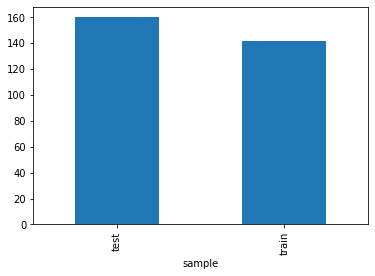

In [105]:
total_df.groupby('sample')['position_have_company'].sum().plot.bar()

<AxesSubplot:xlabel='position_lang'>

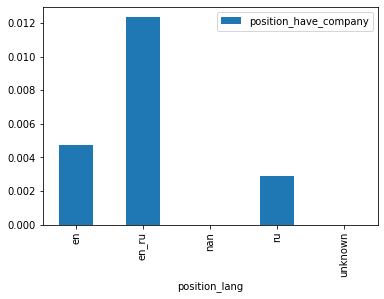

In [106]:
total_df.groupby('position_lang').agg({'position_have_company': lambda x: x.sum() / x.shape[0]}).plot.bar()

<AxesSubplot:xlabel='position_tokens_count'>

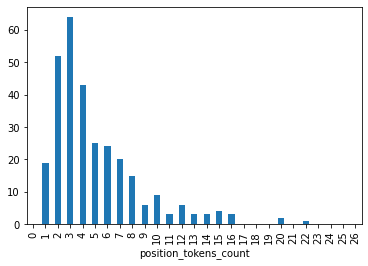

In [107]:
total_df.groupby('position_tokens_count')['position_have_company'].sum().plot.bar()

In [108]:
total_df[(total_df['position_tokens_count'] == 1) & (total_df['position_have_company'] == 1)]['position']

9585               Супермаркет "******"
21931              Практикант на ******
32171                 Заведующий ******
36246                 ****** специалист
38893                   Директор ******
40259                Супервайзер ******
41835                    Ретушер ******
42212                        ООО ******
47806                     Курьер ******
9574                Гастрономика ******
16480                  товаровед ******
19812                   Оператор ******
22460                 ****** специалист
25728                   Продавец ******
31660                 ****** специалист
33664    Представитель ******" (******)
33730              Администратор ******
34847                      ООО "******"
48078              Представитель ******
Name: position, dtype: object

<AxesSubplot:xlabel='position_tokens_count'>

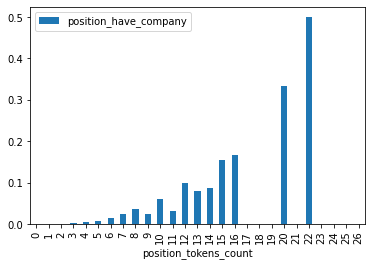

In [109]:
total_df.groupby('position_tokens_count').agg({'position_have_company': lambda x: x.sum() / x.shape[0]}).plot.bar()

<AxesSubplot:xlabel='target'>

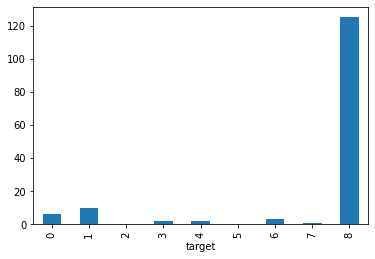

In [110]:
train_expand_df.merge(total_df[['review_id', 'position_have_company',]], how='left', on='review_id').groupby('target')['position_have_company'].sum().plot.bar()

## Рейтинги

Все рейтинги имеют дискретный набор значений от 1 до 5 (в рейтинге карьры иногда встречается значение 0).  
С точки зрения отличий между train и test только в рейтинге зп есть отличия в кол-ве 5 (в train их больше).  
Если посмотреть в разрезе таргета, то можно заметить, что практически для всех рейтингов (кроме командного) наблюдается логичная закономерность, для отзывов непрошедших модерацию преобладают низкие оценки.  
С точки зрения корреляции, практически между всеми рейтингами (кроме командного) наблюдается статисческая связь, коэффициент корреляции больше 0.6.  
Можно заметить что рейтинг команды немного выбивается из общих паттернов, возмозно это связано с тем, что людям в основном нравятся те с кем они работают независимо от остальных условий

##### Код:

In [111]:
rating_cols = total_df.columns[total_df.columns.str.contains('_rating')]
rating_cols

Index(['salary_rating', 'team_rating', 'managment_rating', 'career_rating',
       'workplace_rating', 'rest_recovery_rating'],
      dtype='object')

In [112]:
rating_col = rating_cols[0]
rating_col

'salary_rating'

<AxesSubplot:xlabel='salary_rating', ylabel='count'>

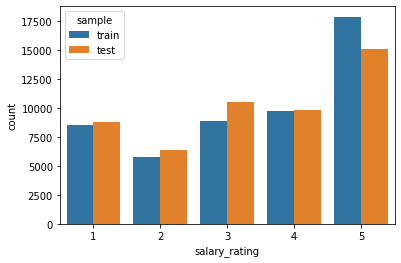

In [113]:
sns.countplot(data=total_df, x=rating_col, hue='sample')

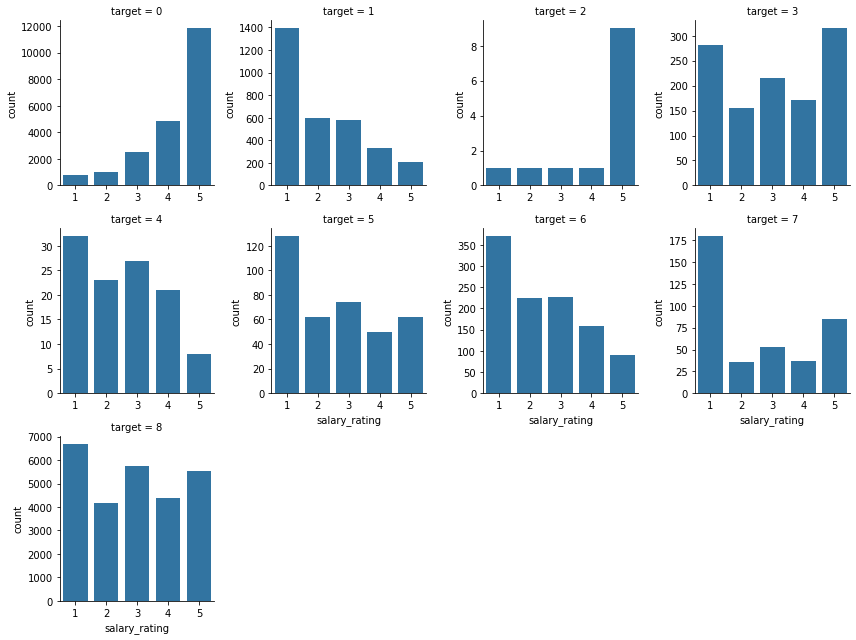

In [114]:
grid = sns.FacetGrid(data=train_expand_df,
                     col='target', col_wrap=4,
                     sharex=False, sharey=False, )
grid.map_dataframe(sns.countplot, x=rating_col, )

In [115]:
rating_col = rating_cols[1]
rating_col

'team_rating'

<AxesSubplot:xlabel='team_rating', ylabel='count'>

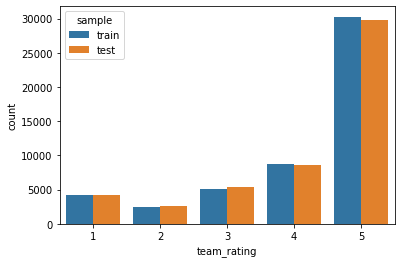

In [116]:
sns.countplot(data=total_df, x=rating_col, hue='sample')

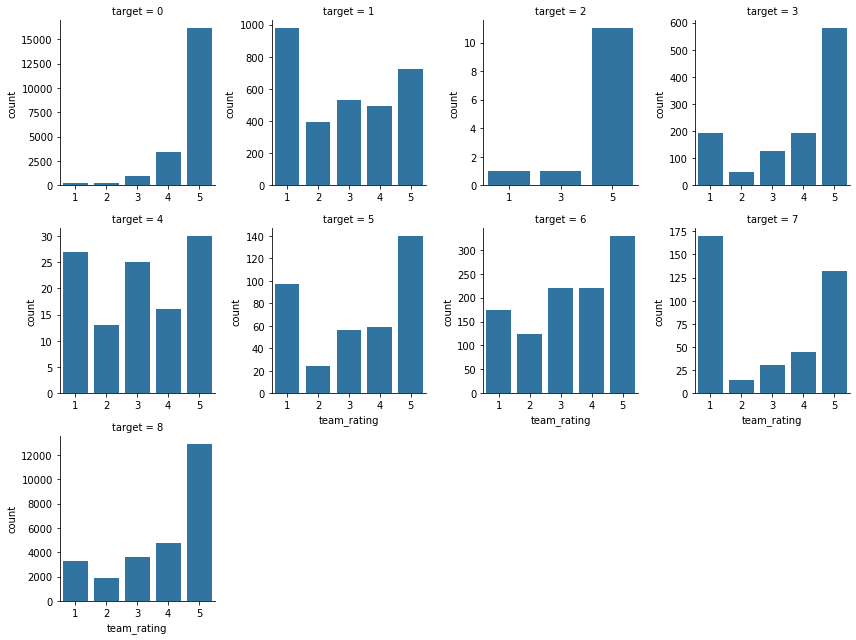

In [117]:
grid = sns.FacetGrid(data=train_expand_df,
                     col='target', col_wrap=4,
                     sharex=False, sharey=False, )
grid.map_dataframe(sns.countplot, x=rating_col, )

In [118]:
rating_col = rating_cols[2]
rating_col

'managment_rating'

<AxesSubplot:xlabel='managment_rating', ylabel='count'>

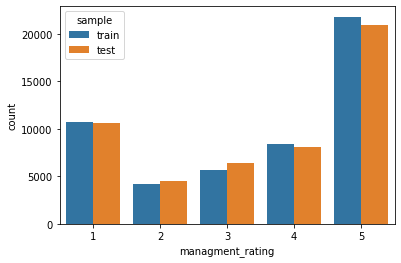

In [119]:
sns.countplot(data=total_df, x=rating_col, hue='sample')

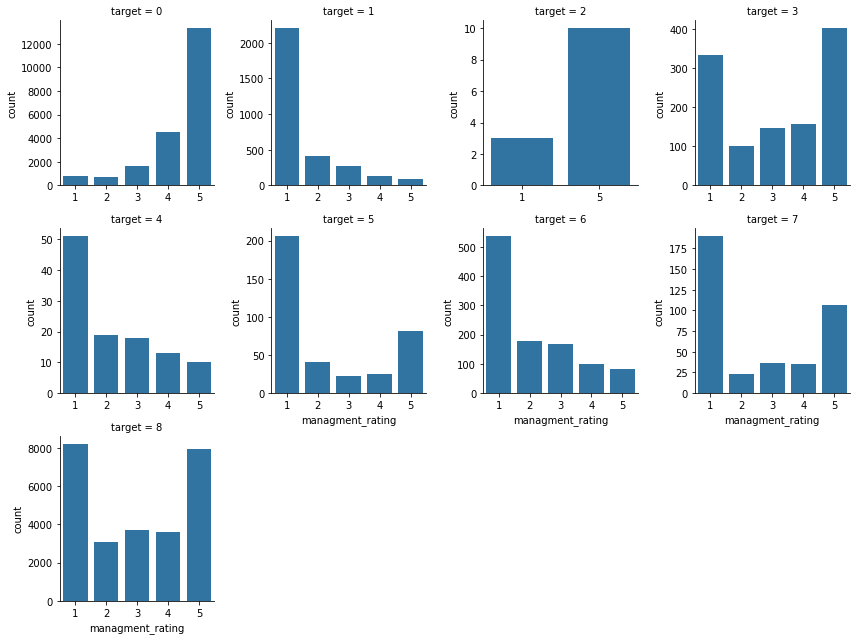

In [120]:
grid = sns.FacetGrid(data=train_expand_df,
                     col='target', col_wrap=4,
                     sharex=False, sharey=False, )
grid.map_dataframe(sns.countplot, x=rating_col, )

In [121]:
rating_col = rating_cols[3]
rating_col

'career_rating'

<AxesSubplot:xlabel='career_rating', ylabel='count'>

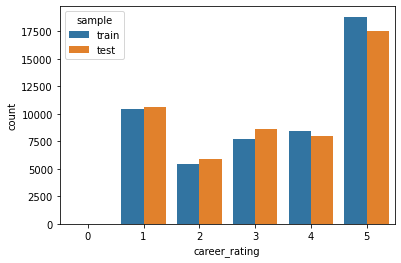

In [122]:
sns.countplot(data=total_df, x=rating_col, hue='sample')

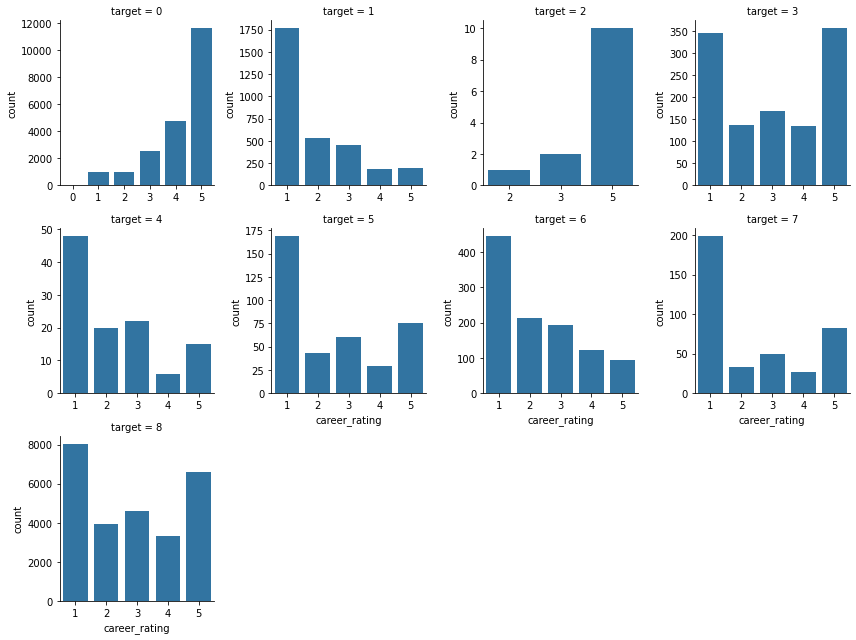

In [123]:
grid = sns.FacetGrid(data=train_expand_df,
                     col='target', col_wrap=4,
                     sharex=False, sharey=False, )
grid.map_dataframe(sns.countplot, x=rating_col, )

In [124]:
rating_col = rating_cols[4]
rating_col

'workplace_rating'

<AxesSubplot:xlabel='workplace_rating', ylabel='count'>

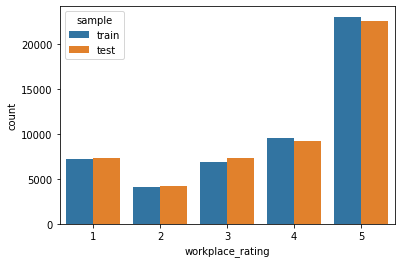

In [125]:
sns.countplot(data=total_df, x=rating_col, hue='sample')

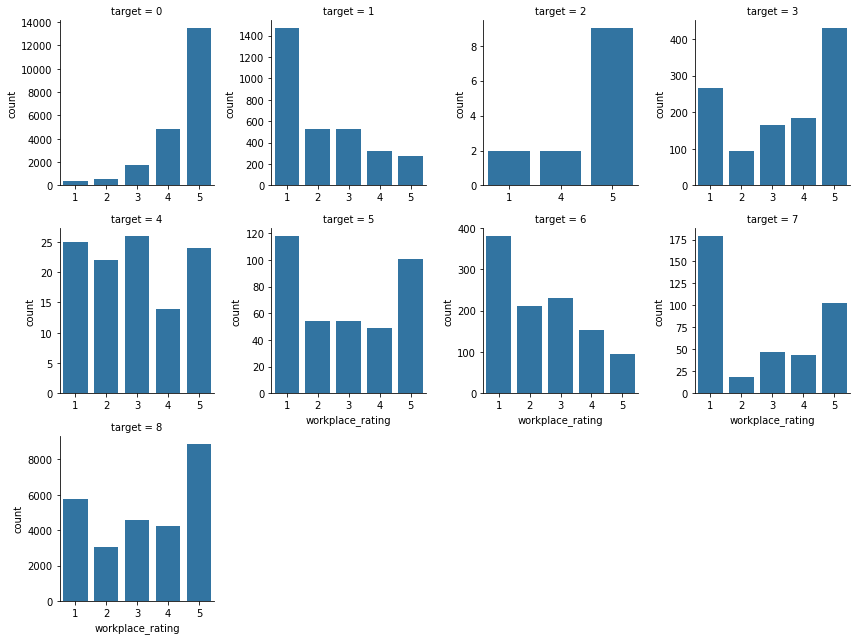

In [126]:
grid = sns.FacetGrid(data=train_expand_df,
                     col='target', col_wrap=4,
                     sharex=False, sharey=False, )
grid.map_dataframe(sns.countplot, x=rating_col, )

In [127]:
rating_col = rating_cols[5]
rating_col

'rest_recovery_rating'

<AxesSubplot:xlabel='rest_recovery_rating', ylabel='count'>

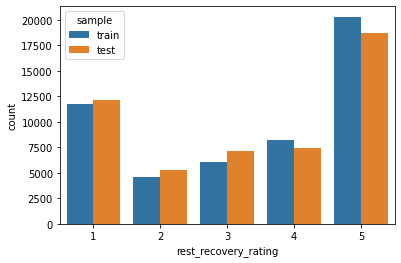

In [128]:
sns.countplot(data=total_df, x=rating_col, hue='sample')

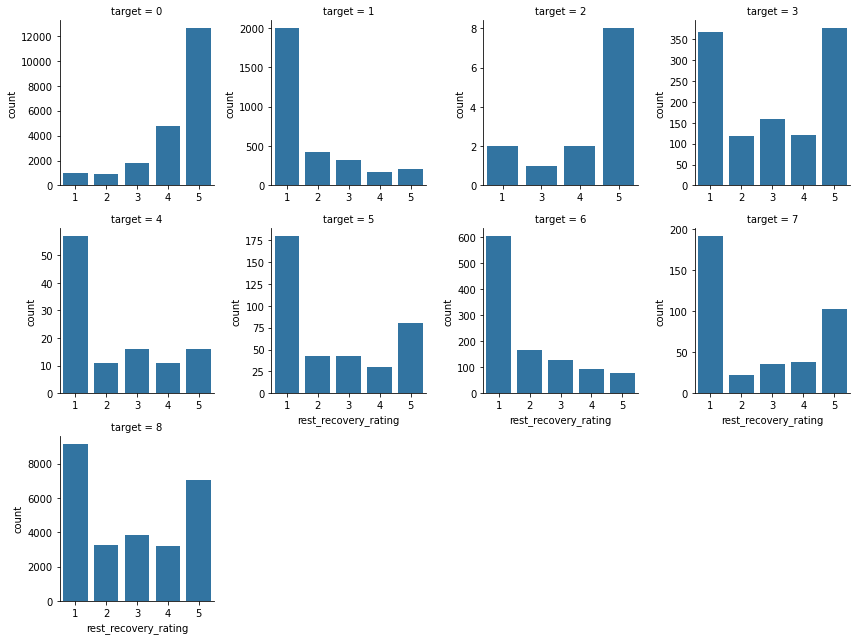

In [129]:
grid = sns.FacetGrid(data=train_expand_df,
                     col='target', col_wrap=4,
                     sharex=False, sharey=False, )
grid.map_dataframe(sns.countplot, x=rating_col, )

<AxesSubplot:>

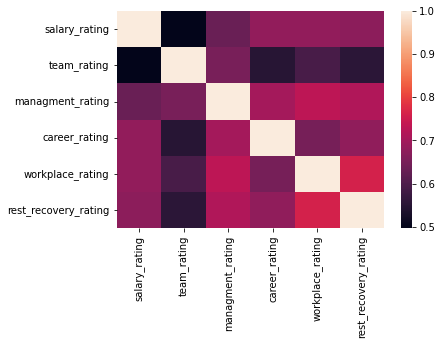

In [130]:
sns.heatmap(data=total_df[rating_cols].corr())

## "Позитивный" и "негативный" отзывы

Данные поля содержат текст в произвольной форме.
Этот текст может быть написан как чисто на русском или английском, так и содержать текст на обоих языках (в основном это просто какие-то англицизмы), однако в большинстве это только русский.  
Отзыв может состоять из одного и более "осмысленных" слов (в основном 3 и 4).  
В отзывах также как и в "Должности" встречаются зацензуренные части (скорее всего название компании).  

В позитивных отзывах:
- с точки зрения языкак отзыва:
   - значимых отличий между train и test нет
   - есть отзывы для которых язык не определен, это в основном всякая тарабарщина и она характерна в основном для 3 причины
- с точки зрения кол-ва слов:
   - отзывы содержат до 30 слов
   - можно заметить что отзывы с русским и английским содержат больше слов
   - значимых отличий между train и test нет
   - в разрезе таргета для 1-8 можно заметить что кол-во токенов больше
- с точки зрения "цензуры":
   - в train цензуры значительно больше чем в test
   - можно заметить что цензура характерна для 0 причины

В негативных отзывах:
- с точки зрения языкак отзыва и кол-ва слов наблюдаются похожие закономерности, как в положительных отзывах
- с точки зрения "цензуры":
   - в train цензуры больше чем в test, но разница не такая сильная как в положительных отзывах
   - можно заметить что цензура чуть более характерна для 0 и 8 причины

#### Код:

In [131]:
total_df[['review_id', 'positive', 'negative']].describe(include='all')

,review_id,positive,negative
count,101527.000000,101487,101387
unique,NaN,92228,89316
top,NaN,Свобода в выборе рабочего графика,Коммуникация между сотрудниками
freq,NaN,300,726
mean,96298.570154,NaN,NaN
std,55659.853998,NaN,NaN
min,0.000000,NaN,NaN
25%,47995.000000,NaN,NaN
50%,96249.000000,NaN,NaN
75%,144499.000000,NaN,NaN


##### Позитивные отзывы

In [132]:
mask = total_df['positive'].notna()
total_df.loc[mask, 'positive_preproc'] = total_df[mask]['positive'].astype(str).map(preproc_str)

mask = total_df['positive_preproc'].notna()
total_df['positive_lang'] = total_df['positive_preproc'].apply(str)
total_df.loc[mask, 'positive_lang'] = 'unknown'
total_df.loc[mask & total_df['positive_preproc'].str.contains('[a-zA-Z]+'),'positive_lang'] = 'en'
total_df.loc[mask & total_df['positive_preproc'].str.contains('[а-яА-Я]+'),'positive_lang'] = 'ru'
total_df.loc[mask & total_df['positive_preproc'].str.contains('[a-zA-Z]+') & total_df['positive_preproc'].str.contains('[а-яА-Я]+'),'positive_lang'] = 'en_ru'

total_df['positive_tokens_count'] = 0
mask = total_df['positive_lang'] == 'ru'
total_df.loc[mask, 'positive_tokens_count'] = total_df[mask]['positive_preproc'].apply(lambda x: len(tokenize(x, ru_stop_words)))
mask = total_df['positive_lang'] == 'en'
total_df.loc[mask, 'positive_tokens_count'] = total_df[mask]['positive_preproc'].apply(lambda x: len(tokenize(x, en_stop_words)))
mask = total_df['positive_lang'] == 'en_ru'
total_df.loc[mask, 'positive_tokens_count'] = total_df[mask]['positive_preproc'].apply(lambda x: len(tokenize(x, all_stop_words)))

# mask = total_df['positive_preproc'].notna() & (total_df['positive_preproc'].str.len() != 0)
# total_df.loc[mask, 'positive_norm'] = total_df[mask]['positive_preproc'].apply(position_normalize)

mask = total_df['positive'].notna()
total_df.loc[mask, 'positive_have_company'] = total_df[mask]['positive'].str.contains('[\*]+').astype(int)

total_df[['positive', 'positive_preproc', 'positive_lang', 'positive_tokens_count', 'positive_have_company']].head()

,positive,positive_preproc,positive_lang,positive_tokens_count,positive_have_company
0,Недавно устроился в ****** на должность кладов...,недавно устроился в на должность кладов...,ru,22,1.0
1,"Расположение офиса, своего рода стабильность (...",расположение офиса своего рода стабильность ...,ru,6,0.0
2,В нашем банке все по закону в плане зарплаты и...,в нашем банке все по закону в плане зарплаты и...,ru,26,0.0
3,Я в ****** около года работаю оператором. Норм...,я в около года работаю оператором норм...,ru,17,1.0
4,В принципе норм.Работать можно,в принципе норм работать можно,ru,3,0.0


<AxesSubplot:xlabel='positive_lang', ylabel='count'>

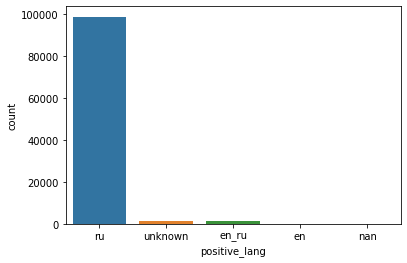

In [133]:
sns.countplot(data=total_df, x='positive_lang')

In [134]:
total_df[total_df['positive_lang'] == 'unknown']['positive']

14              .......................
230             ***********************
259                ....................
434      ..............................
632          ..........................
                      ...              
50225           .......................
50268            ......................
50334       ...........................
50405       ...........................
50531           ¡!!!!!!!!!!!!!!!!!!!!!¡
Name: positive, Length: 1293, dtype: object

In [135]:
total_df[total_df['positive_lang'] == 'en_ru']['positive'].values[:1]

array(['В проектах можно развить новые навыки и получить новые знания. Менеджеры проектов ведут проекты только вперед и строят хорошие отношения в команде. Отличное командообразование. Коммуникации во всех командах деловые и учтивые. Компания предоставляет возможности карьерного роста и релокации. Немаловажно наличие Тренинг Центра и множества обучающих вебинаров, проводимых сотрудниками компании. Есть много внепроектных активностей: English club, handmade club, танцы, спорт и т. д. В компании оформляется ДМС. Офис большой и светлый.'],
      dtype=object)

In [136]:
total_df[total_df['positive_lang'] == 'en']['positive'].head()

2247    ****** provides a lot of opportunity to work o...
5241                           Gggggvvvgg5ujhhhhhuyyyyhyh
5935                              Ffewfhhhgewqe2ewwszaqsd
6314    marystarkova@gmail.commarystarkova@gmail.comma...
7289                             Svobodaaaaaaaaaaaaaaaaaa
Name: positive, dtype: object

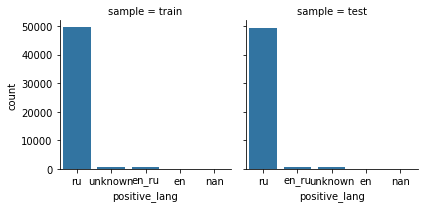

In [137]:
grid = sns.FacetGrid(total_df,
                     col='sample', 
                     sharex=False, )
grid.map_dataframe(sns.countplot, x='positive_lang')

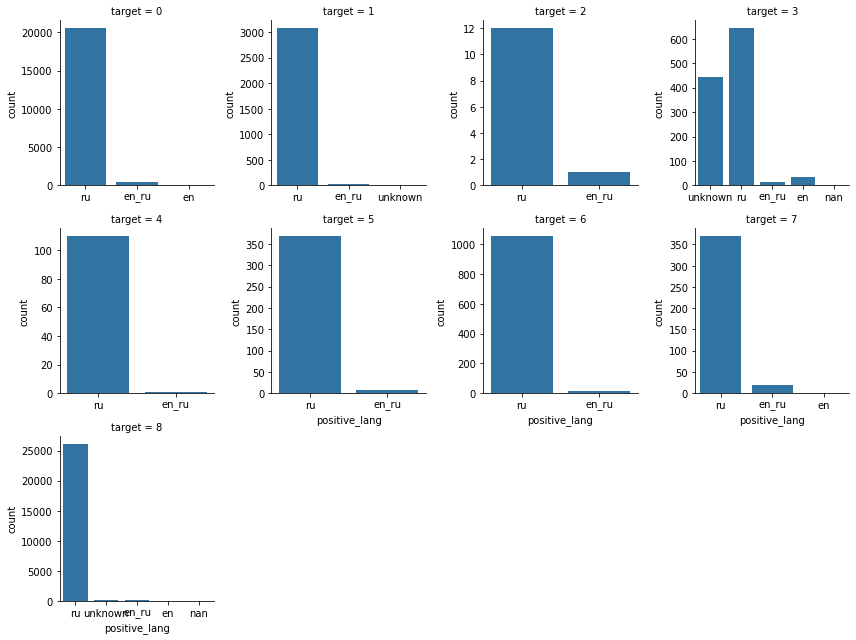

In [138]:
grid = sns.FacetGrid(train_expand_df.merge(total_df[['review_id', 'positive_lang', ]], how='left', on='review_id'),
                     col='target', col_wrap=4,
                     sharex=False, sharey=False, )
grid.map_dataframe(sns.countplot, x='positive_lang')

<AxesSubplot:xlabel='positive_tokens_count'>

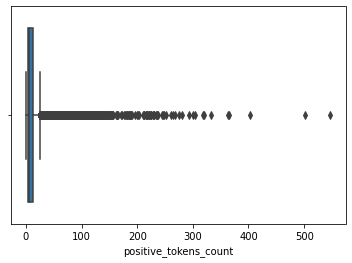

In [139]:
sns.boxplot(data=total_df, x='positive_tokens_count', )

<AxesSubplot:xlabel='positive_tokens_count', ylabel='count'>

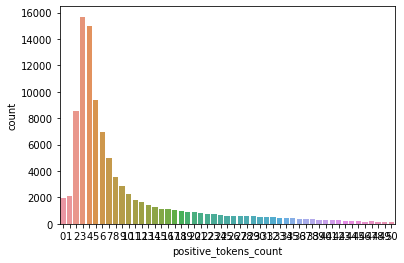

In [140]:
sns.countplot(data=total_df[total_df['positive_tokens_count'] <= 50], x='positive_tokens_count', )

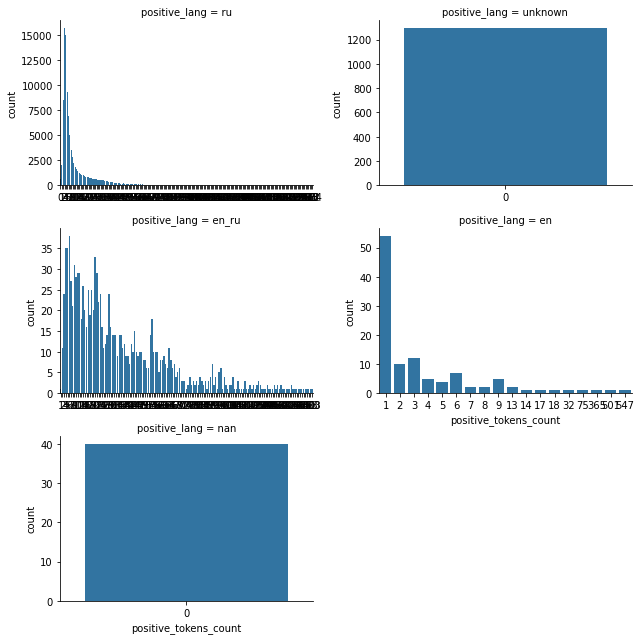

In [141]:
grid = sns.FacetGrid(total_df,
                     col='positive_lang', col_wrap=2,
                     sharex=False, sharey=False, 
                     aspect=1.5, )
grid.map_dataframe(sns.countplot, x='positive_tokens_count')

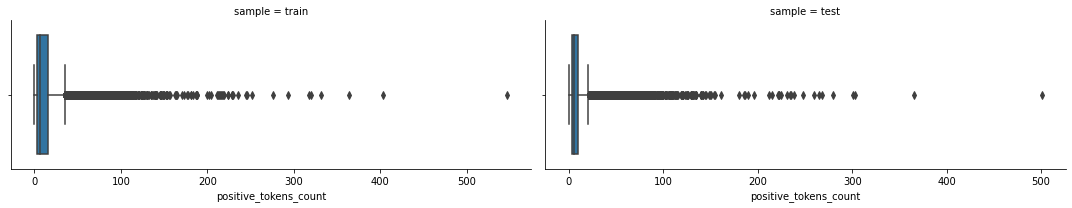

In [142]:
grid = sns.FacetGrid(total_df,
                     col='sample', 
                     sharex=False, 
                     aspect=2.5, )
grid.map_dataframe(sns.boxplot, x='positive_tokens_count')

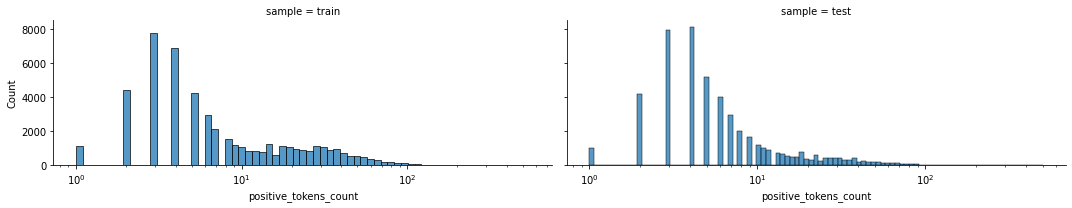

In [143]:
grid = sns.FacetGrid(total_df[total_df['positive_tokens_count'] != 0],
                     col='sample', 
                     sharex=False, 
                     aspect=2.5, )
grid.map_dataframe(sns.histplot, x='positive_tokens_count', log_scale=True)

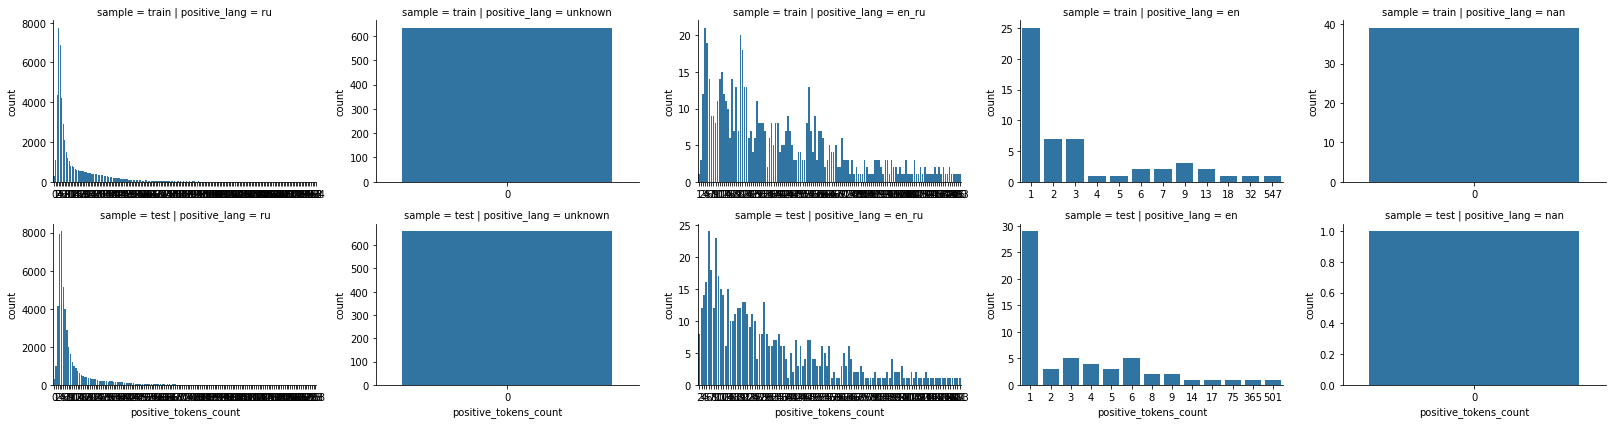

In [144]:
grid = sns.FacetGrid(total_df,
                     row='sample', col='positive_lang', 
                     sharex=False, sharey=False, 
                     aspect=1.5, )
grid.map_dataframe(sns.countplot, x='positive_tokens_count')

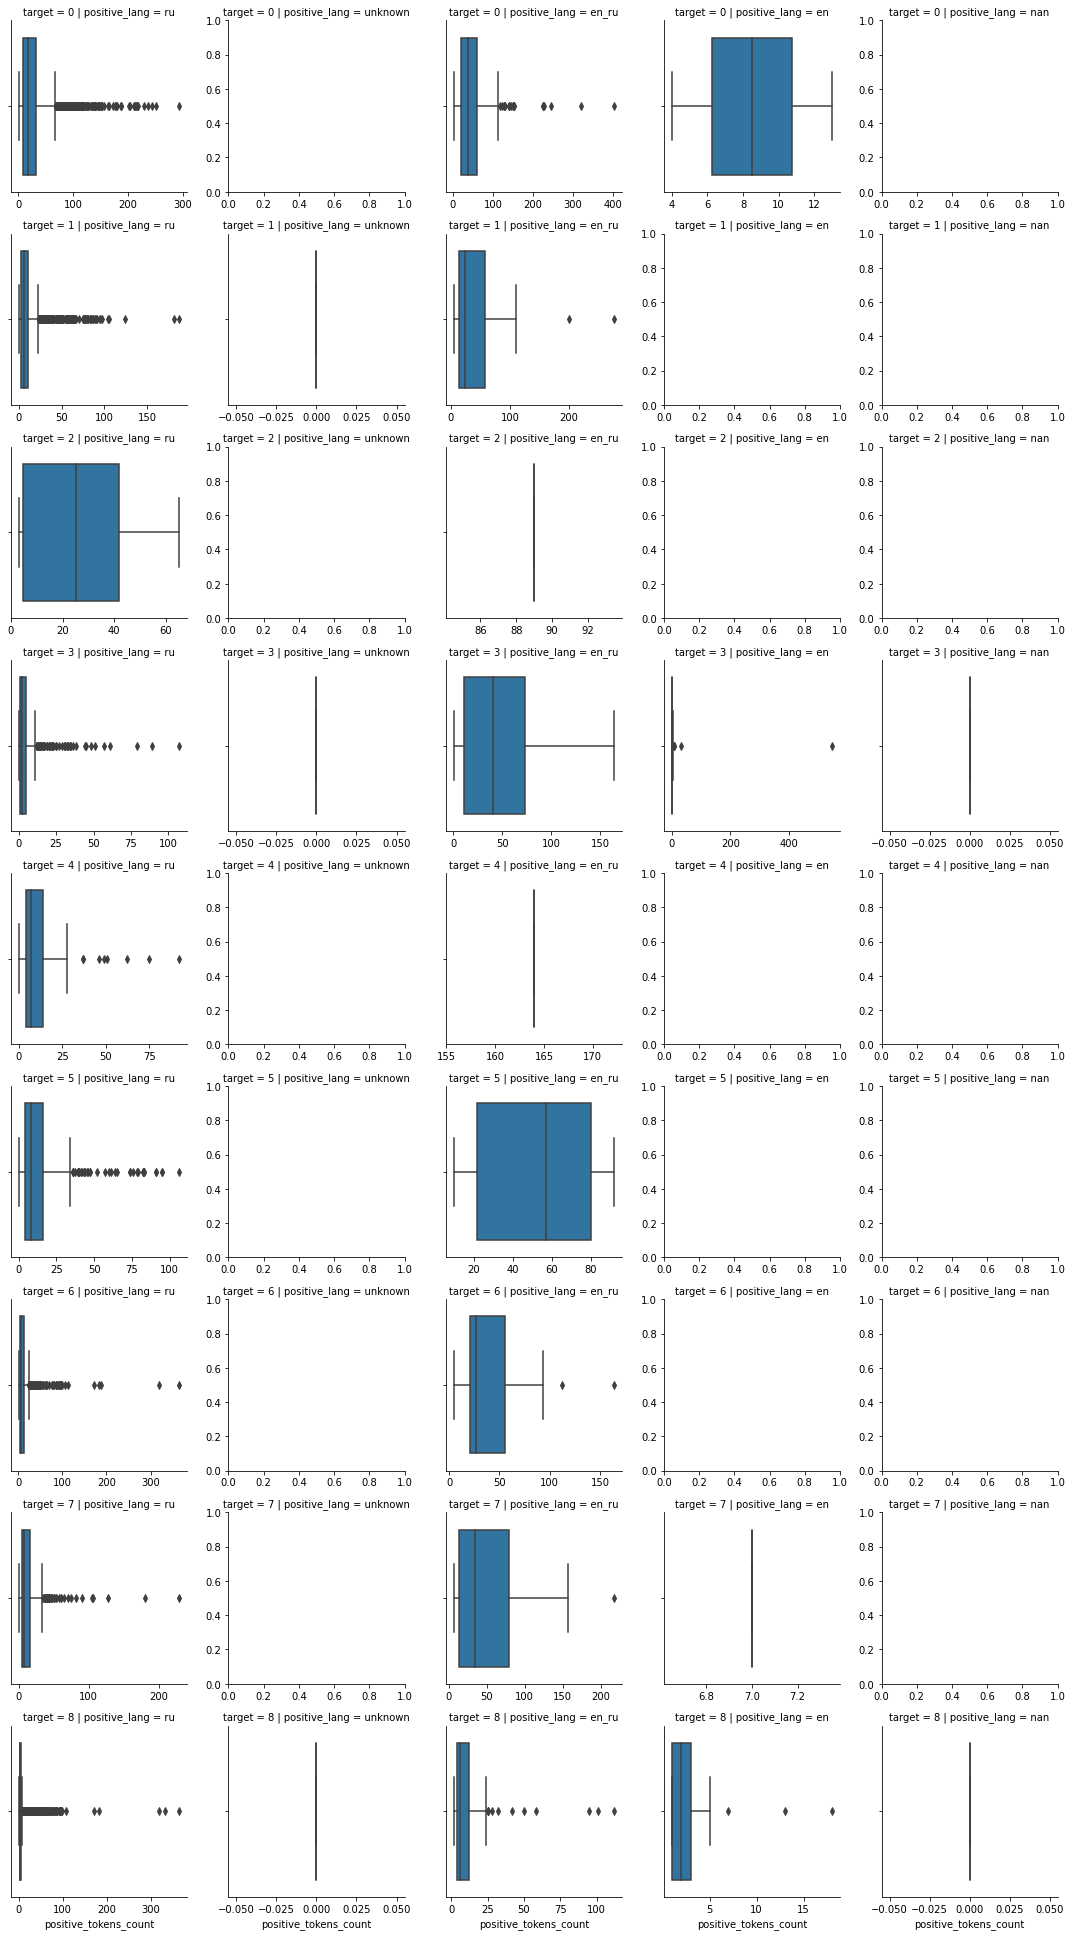

In [145]:
grid = sns.FacetGrid(train_expand_df.merge(total_df[['review_id', 'positive_lang', 'positive_tokens_count']], how='left', on='review_id'),
                     row='target', col='positive_lang', 
                     sharex=False, sharey=False, )
grid.map_dataframe(sns.boxplot, x='positive_tokens_count')

In [146]:
total_df['positive_have_company'].value_counts(dropna=False)

0.0    94642
1.0     6845
NaN       40
Name: positive_have_company, dtype: int64

<AxesSubplot:xlabel='sample'>

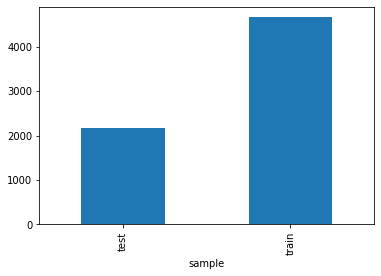

In [147]:
total_df.groupby('sample')['positive_have_company'].sum().plot.bar()

<AxesSubplot:xlabel='position_lang'>

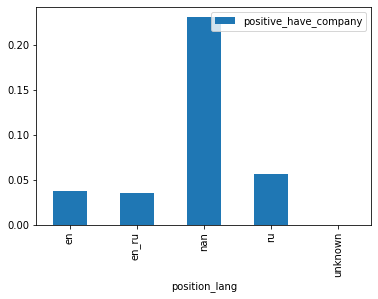

In [148]:
total_df.groupby('positive_lang').agg({'positive_have_company': lambda x: x.sum() / x.shape[0]}).plot.bar()

<AxesSubplot:xlabel='positive_tokens_count'>

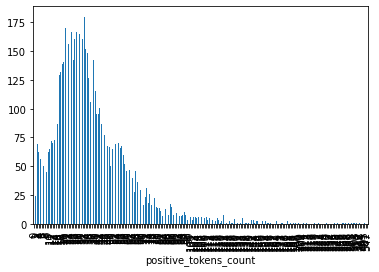

In [149]:
total_df.groupby('positive_tokens_count')['positive_have_company'].sum().plot.bar()

In [150]:
total_df[(total_df['positive_tokens_count'] == 1) & (total_df['positive_have_company'] == 1)]['positive']

9783                    Ничего хорошего в ******
10165                Ничего не нравится в ******
10897                            Компания ******
12925    В ******  не может  нравиться  что то..
15893               Ничего хорошего нет в ******
20351                Ничего. Нищета, а не ******
21326                Ничего не нравится в ******
21810               Ничего хорошего нет в ******
23128                *ааааадыщылыововшыщыщвщщввщ
27524                          Ничего,это ******
27767             Один словами ****** лучше всех
29883               Ничего хорошего нет в ******
30596                      В ****** все отлично.
38623            Ничего мне не нравится в ******
40470                Ничего не нравится в ******
42498               Ничего хорошего нет в ******
43551             Ничего хорошего в ****** нет !
47091                 Ничего совсем нахуй ******
5136           Ничего хорошего нет в этом ******
5513                Ничего нет хорошего в ******
25852               

<AxesSubplot:xlabel='positive_tokens_count'>

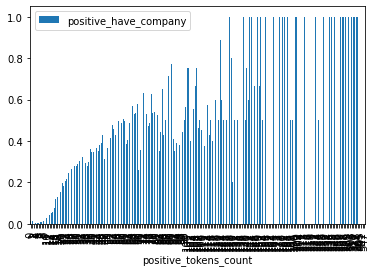

In [151]:
total_df.groupby('positive_tokens_count').agg({'positive_have_company': lambda x: x.sum() / x.shape[0]}).plot.bar()

<AxesSubplot:xlabel='target'>

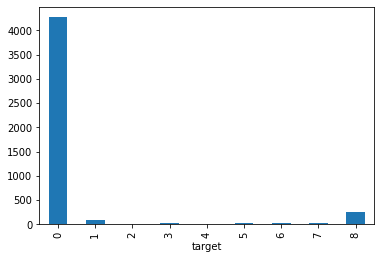

In [152]:
train_expand_df.merge(total_df[['review_id', 'positive_have_company',]], how='left', on='review_id').groupby('target')['positive_have_company'].sum().plot.bar()

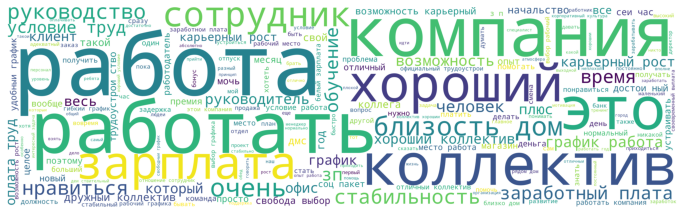

In [153]:
ru_words = ' '.join(total_df[total_df['positive_lang'] == 'ru']['positive_preproc'].sample(10_000).map(position_normalize))
plot_words(ru_words)

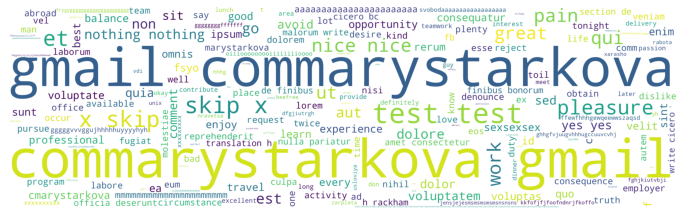

In [154]:
en_words = ' '.join(total_df[total_df['positive_lang'] == 'en']['positive_preproc'].map(position_normalize))
plot_words(en_words)

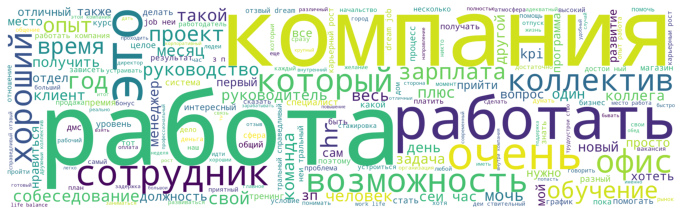

In [155]:
en_ru_words = ' '.join(total_df[total_df['positive_lang'] == 'en_ru']['positive_preproc'].map(position_normalize))
plot_words(en_ru_words)

##### Негативные отзывы

In [156]:
mask = total_df['negative'].notna()
total_df.loc[mask, 'negative_preproc'] = total_df[mask]['negative'].map(preproc_str)

mask = total_df['negative_preproc'].notna()
total_df['negative_lang'] = total_df['negative_preproc'].apply(str)
total_df.loc[mask, 'negative_lang'] = 'unknown'
total_df.loc[mask & total_df['negative_preproc'].str.contains('[a-zA-Z]+'),'negative_lang'] = 'en'
total_df.loc[mask & total_df['negative_preproc'].str.contains('[а-яА-Я]+'),'negative_lang'] = 'ru'
total_df.loc[mask & total_df['negative_preproc'].str.contains('[a-zA-Z]+') & total_df['negative_preproc'].str.contains('[а-яА-Я]+'),'negative_lang'] = 'en_ru'

total_df['negative_tokens_count'] = 0
mask = total_df['negative_lang'] == 'ru'
total_df.loc[mask, 'negative_tokens_count'] = total_df[mask]['negative_preproc'].apply(lambda x: len(tokenize(x, ru_stop_words)))
mask = total_df['negative_lang'] == 'en'
total_df.loc[mask, 'negative_tokens_count'] = total_df[mask]['negative_preproc'].apply(lambda x: len(tokenize(x, en_stop_words)))
mask = total_df['negative_lang'] == 'en_ru'
total_df.loc[mask, 'negative_tokens_count'] = total_df[mask]['negative_preproc'].apply(lambda x: len(tokenize(x, all_stop_words)))

# mask = total_df['negative_preproc'].notna() & (total_df['negative_preproc'].str.len() != 0)
# total_df.loc[mask, 'negative_norm'] = total_df[mask]['negative_preproc'].apply(position_normalize)

mask = total_df['negative'].notna()
total_df.loc[mask, 'negative_have_company'] = total_df[mask]['negative'].str.contains('[\*]+').astype(int)

total_df[['negative', 'negative_preproc', 'negative_lang', 'negative_tokens_count', 'negative_have_company']].head()

,negative,negative_preproc,negative_lang,negative_tokens_count,negative_have_company
0,Повысить з/п,повысить з п,ru,3,0.0
1,Упростить процессы - все процессы ради процесс...,упростить процессы все процессы ради процесс...,ru,32,0.0
2,Ничего,ничего,ru,0,0.0
3,Нет.,нет,ru,0,0.0
4,Всегда есть к чему стремиться,всегда есть к чему стремиться,ru,2,0.0


<AxesSubplot:xlabel='negative_lang', ylabel='count'>

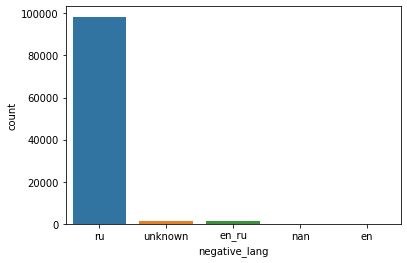

In [157]:
sns.countplot(data=total_df, x='negative_lang')

In [158]:
total_df[total_df['negative_lang'] == 'unknown']['negative']

14                    ......................
72                                         -
230                  ***********************
434        .................................
530                                        -
                        ...                 
50291                                      -
50334         ..............................
50405                .......................
50531                ¡!!!!!!!!!!!!!!!!!!!!!!
50640    .......    .............. .........
Name: negative, Length: 1489, dtype: object

In [159]:
total_df[total_df['negative_lang'] == 'en_ru']['negative'].values[:1]

array(['crm иногда глючит, но\xa0это не\xa0так критично.'], dtype=object)

In [168]:
total_df[total_df['negative_lang'] == 'en']['negative'].head()

2247    Few more benefits would be good to have like b...
5241                          Hhf[ggggcfcccxxxxxddddsertg
5935                              Qqqqq2wwwqqqqqqwwwwqqwq
6314    marystarkova@gmail.commarystarkova@gmail.comma...
7468                         Xxxxxxxxxxxxxxxxxxxxxxxxxxxx
Name: negative, dtype: object

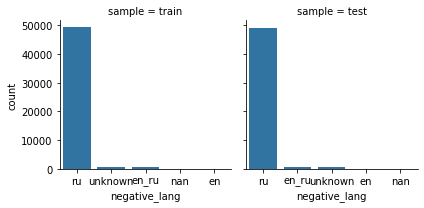

In [169]:
grid = sns.FacetGrid(total_df,
                     col='sample', 
                     sharex=False, )
grid.map_dataframe(sns.countplot, x='negative_lang')

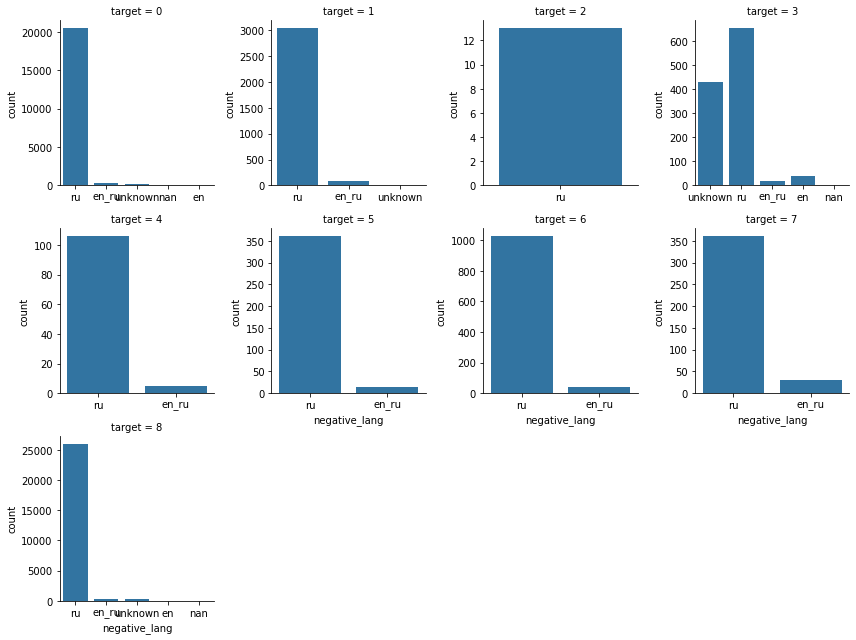

In [170]:
grid = sns.FacetGrid(train_expand_df.merge(total_df[['review_id', 'negative_lang', ]], how='left', on='review_id'),
                     col='target', col_wrap=4,
                     sharex=False, sharey=False, )
grid.map_dataframe(sns.countplot, x='negative_lang')

<AxesSubplot:xlabel='negative_tokens_count'>

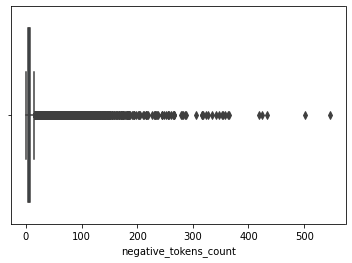

In [171]:
sns.boxplot(data=total_df, x='negative_tokens_count', )

<AxesSubplot:xlabel='negative_tokens_count', ylabel='count'>

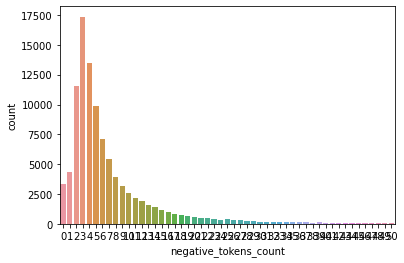

In [172]:
sns.countplot(data=total_df[total_df['negative_tokens_count'] <= 50], x='negative_tokens_count', )

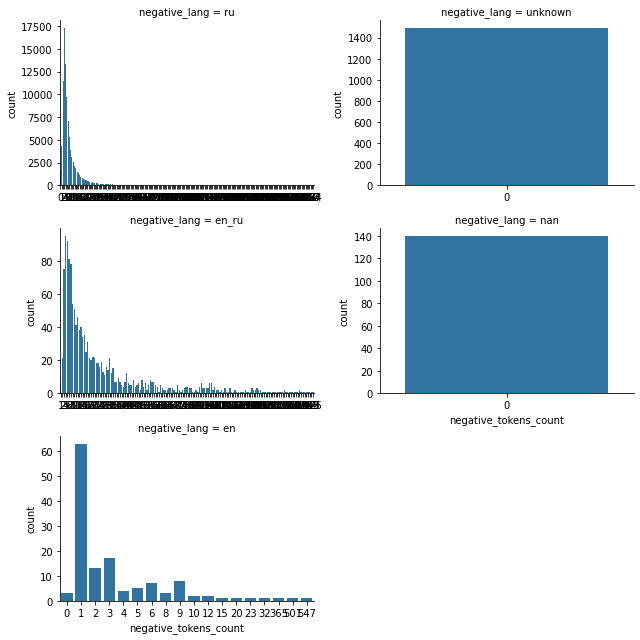

In [173]:
grid = sns.FacetGrid(total_df,
                     col='negative_lang', col_wrap=2,
                     sharex=False, sharey=False, 
                     aspect=1.5, )
grid.map_dataframe(sns.countplot, x='negative_tokens_count')

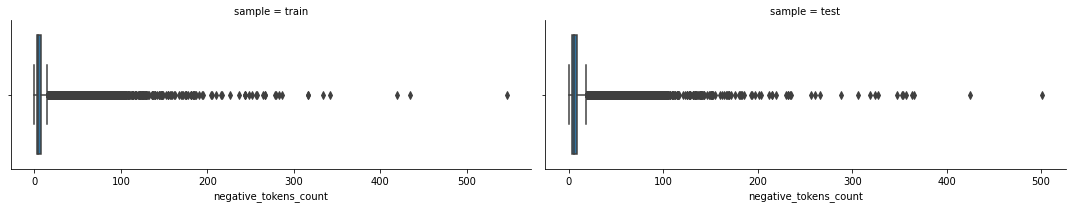

In [174]:
grid = sns.FacetGrid(total_df,
                     col='sample', 
                     sharex=False, 
                     aspect=2.5, )
grid.map_dataframe(sns.boxplot, x='negative_tokens_count')

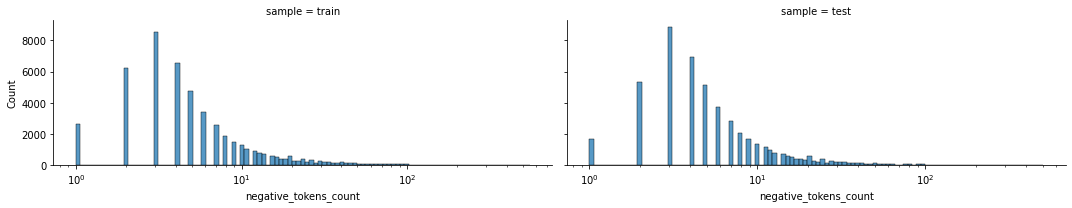

In [175]:
grid = sns.FacetGrid(total_df[total_df['negative_tokens_count'] != 0],
                     col='sample', 
                     sharex=False, 
                     aspect=2.5, )
grid.map_dataframe(sns.histplot, x='negative_tokens_count', log_scale=True)

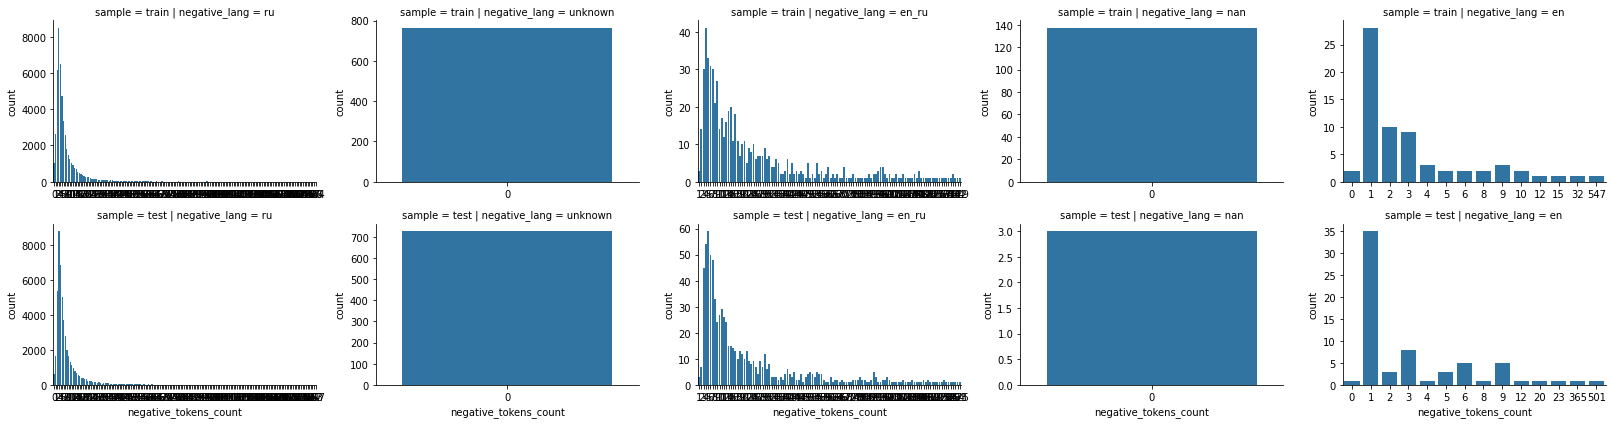

In [176]:
grid = sns.FacetGrid(total_df,
                     row='sample', col='negative_lang', 
                     sharex=False, sharey=False, 
                     aspect=1.5, )
grid.map_dataframe(sns.countplot, x='negative_tokens_count')

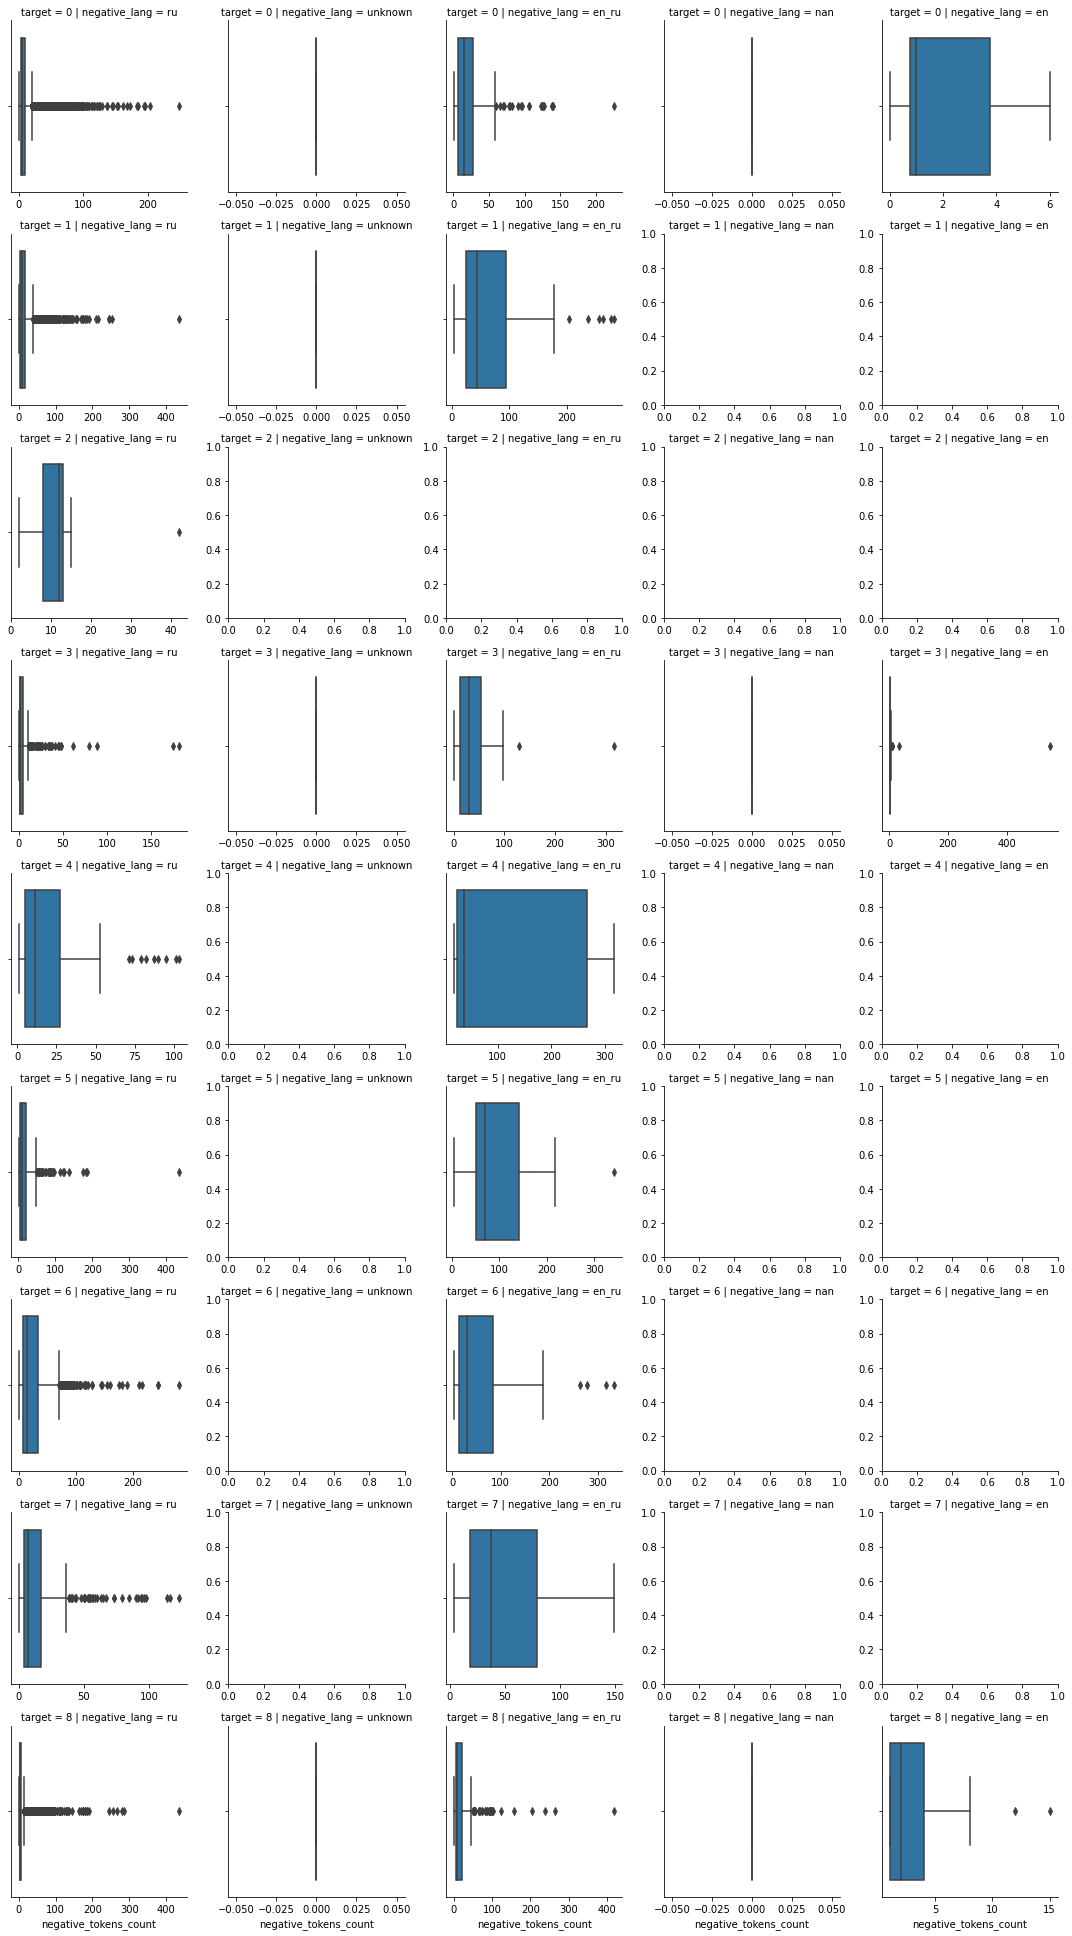

In [177]:
grid = sns.FacetGrid(train_expand_df.merge(total_df[['review_id', 'negative_lang', 'negative_tokens_count']], how='left', on='review_id'),
                     row='target', col='negative_lang', 
                     sharex=False, sharey=False, )
grid.map_dataframe(sns.boxplot, x='negative_tokens_count')

In [178]:
total_df['negative_have_company'].value_counts(dropna=False)

0.0    99803
1.0     1584
NaN      140
Name: negative_have_company, dtype: int64

<AxesSubplot:xlabel='sample'>

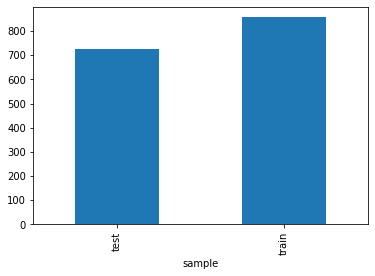

In [179]:
total_df.groupby('sample')['negative_have_company'].sum().plot.bar()

<AxesSubplot:xlabel='negative_lang'>

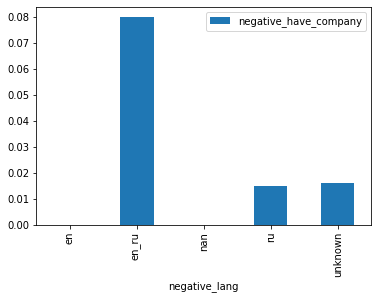

In [180]:
total_df.groupby('negative_lang').agg({'negative_have_company': lambda x: x.sum() / x.shape[0]}).plot.bar()

<AxesSubplot:xlabel='negative_tokens_count'>

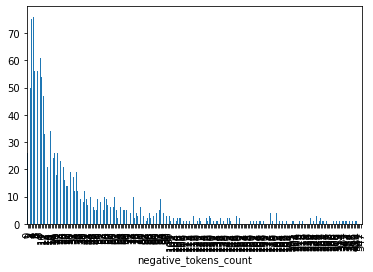

In [181]:
total_df.groupby('negative_tokens_count')['negative_have_company'].sum().plot.bar()

In [182]:
total_df[(total_df['negative_tokens_count'] == 1) & (total_df['negative_have_company'] == 1)]['negative']

1038                          Мне в ****** нравится.
1295                    Меня Все устраивало в ******
3630                                 Верните ******?
10639                            ****** мне подходит
10897                                Компанию ******
12084                       Так-то в ****** здорово)
13687                            ****** все испортил
25936    Если бы только все компании были как ******
26314                          Не обединять с ******
27653                   Да всё хорошо и так в ******
30923                  ****** и так все сам улучшает
35773                       Все надо менять в ******
46017                          ******, помочь нельзя
608                            К ****** нет вопросов
1387                    Больше ****** - больше денег
22883                Все может быть луче, чем ******
Name: negative, dtype: object

<AxesSubplot:xlabel='negative_tokens_count'>

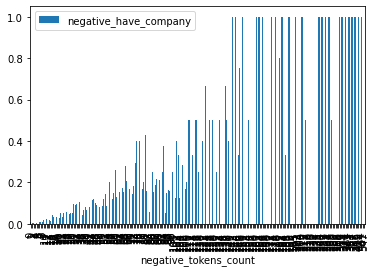

In [183]:
total_df.groupby('negative_tokens_count').agg({'negative_have_company': lambda x: x.sum() / x.shape[0]}).plot.bar()

<AxesSubplot:xlabel='target'>

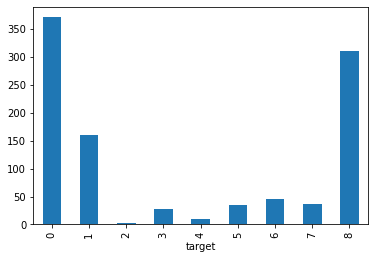

In [184]:
train_expand_df.merge(total_df[['review_id', 'negative_have_company',]], how='left', on='review_id').groupby('target')['negative_have_company'].sum().plot.bar()

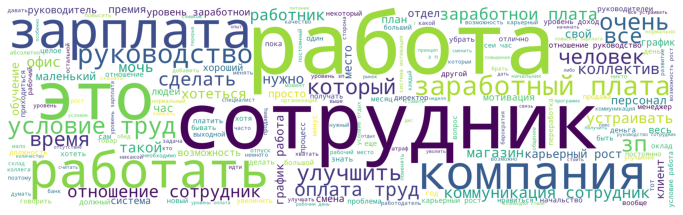

In [185]:
ru_words = ' '.join(total_df[total_df['negative_lang'] == 'ru']['negative_preproc'].sample(10_000).map(position_normalize))
plot_words(ru_words)

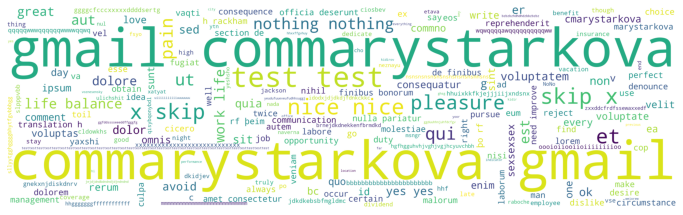

In [186]:
en_words = ' '.join(total_df[total_df['negative_lang'] == 'en']['negative_preproc'].map(position_normalize))
plot_words(en_words)

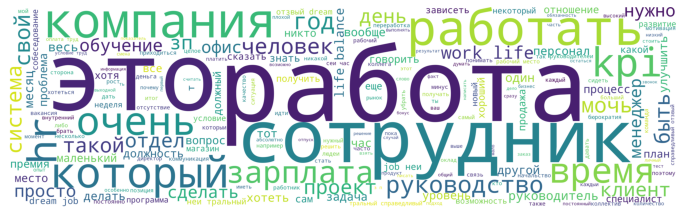

In [187]:
en_ru_words = ' '.join(total_df[total_df['negative_lang'] == 'en_ru']['negative_preproc'].map(position_normalize))
plot_words(en_ru_words)

# Выводы

- есть подозрение что разбиение на train и test не случайное, а зависит от даты, либо разбиение проводилось по людям